# Data Analytics

# Fuente de los datos

Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.

In [1]:
# Libraries
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from collections import Counter
from scipy.stats import chi2_contingency

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, auc, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn import set_config

import joblib

In [25]:
warnings.simplefilter("ignore")
set_config(enable_metadata_routing=True)

In [3]:
sns.set_theme(style = 'whitegrid', palette = 'muted')
plt.style.use('ggplot')

In [2]:
gen_path = Path().cwd().parent

In [94]:
df = pd.read_csv(gen_path / 'data' / 'diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [46]:
df['payer_code'].unique()

array(['?', 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM',
       'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR'], dtype=object)

In [47]:
Counter(df['payer_code'])

Counter({'?': 40256,
         'MC': 32439,
         'HM': 6274,
         'SP': 5007,
         'BC': 4655,
         'MD': 3532,
         'CP': 2533,
         'UN': 2448,
         'CM': 1937,
         'OG': 1033,
         'PO': 592,
         'DM': 549,
         'CH': 146,
         'WC': 135,
         'OT': 95,
         'MP': 79,
         'SI': 55,
         'FR': 1})

In [6]:
pd.crosstab(df["readmitted"], df["payer_code"])

payer_code,?,BC,CH,CM,CP,DM,FR,HM,MC,MD,MP,OG,OT,PO,SI,SP,UN,WC
readmitted,,,,,,,,,,,,,,,,,,
<30,4627,426,13,198,214,64,0,644,3810,416,9,136,7,44,7,510,227,5
>30,13828,1301,33,661,781,220,0,2320,11982,1259,39,333,38,144,17,1869,696,24
NO,21801,2928,100,1078,1538,265,1,3310,16647,1857,31,564,50,404,31,2628,1525,106


In [7]:
drop = ['encounter_id', 'patient_nbr', 'gender']

In [8]:
df.info(memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# Eliminación de variables cualitativas

En el conjunto de datos se han encontrado muy pocos datos para 'max_glu_serum' y 'A1Cresult', implicando técnicas de imputación o algún otro método sea muy poco combeniente. Los cantidad de valores valores faltantes representa respectivamente un 94.74% y un 83.28%, por tanto, estas dos variables se retiran. Agregrando, se observar que las demás variables no tienen valores faltantes.

# Tratamiento de variables de mediciones repetidas a observacones independientes

En este caso se cuenta que los datos obtenidos se tienen mediciones 

## Análisis de los faltantes en el DF

En este caso se debe tener cuidado en un aspecto en particular, los datos representados en este estudio cuando no se tenía registro o información sobre un variable cualitativa, sea cual sea esta, esta siempre se le agregaba '?' para indicar desconomiento de dicho dato. En este estudio esos valores se pasan a ser 'NA'.

In [7]:
df.isna().sum()[df.isna().sum() > 0]

max_glu_serum    96420
A1Cresult        84748
dtype: int64

In [8]:
df.replace('?', pd.NA, inplace= True)

In [9]:
df.isna().sum()[df.isna().sum() > 0]

race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64

In [ ]:
df.shape

### Términos porcentuales

Se van a eleminar aquellas variables continuas que tengan mayor a un 10% de valores faltantes, y aquellos que sean menores a este humbral se les reempazará con el promedio de cada variable. En cambio, aquellas varaibles cualitativas que tengan valores faltantes, independientemente del porcentaje de valores faltantes, se les eliminará de la base de datos.

In [10]:
df.isna().sum()[df.isna().sum() > 0] / df.shape[0] * 100

race                  2.233555
weight               96.858479
payer_code           39.557416
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
max_glu_serum        94.746772
A1Cresult            83.277322
dtype: float64

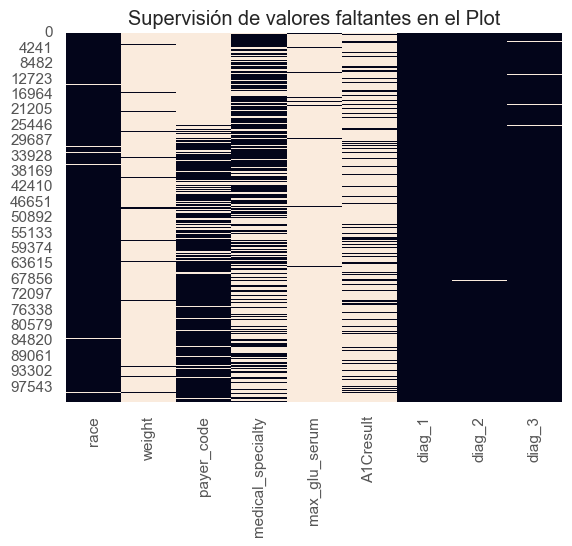

In [11]:
del_var_tot = ['race', 'weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'diag_1', 'diag_2', 'diag_3']
del_var = ['race', 'weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult']

sns.heatmap(df[del_var_tot].isnull(),  cbar= False)
plt.title('Supervisión de valores faltantes en el Plot')
plt.show()

Una vez analizados los datos que no existan valores faltantes u otros elementos extraños, se procede con el análisis de los datos en el desarrollo de modelos predictivos. En este caso se cuenta con diferentes alternativas, por ejemplo se tiene:

1. Multinomial
2. Randoforest
3. Arbol de decisión
4. Xboost
5. Stacking

## Restruccturación de de las variables categoricas

En este caso particular se van a cambiar la estructura de cada una de las variables, por lo cual se van a unir categorías, esto va a ser basandose en criterios en medicina, así como en otros estudios preivos realizados. En este punto la combinación de variables y demás se va a dejar preparada la entrada nueva de datos que no han sufrido las modificaciones y demás acciones para realizar dichas predicciones.

In [16]:
df["age"].unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [4]:
col_age = np.array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'])

In [ ]:
df["age"] = pd.Categorical(df["age"], categories= col_age, ordered= True)
df["age"] = df["age"].cat.codes

Análisis para la distribución de la edad dentro de cada grupo de readmitido

In [19]:
pd.crosstab(df["readmitted"], df["age"])

age,0,1,2,3,4,5,6,7,8,9
readmitted,,,,,,,,,,
<30,3,40,236,424,1027,1668,2502,3069,2078,310
>30,26,224,510,1187,3278,5917,7897,9475,6223,808
NO,132,427,911,2164,5380,9671,12084,13524,8896,1675


Este caso al haber referentes en edades muy tempranos hay una baja representación de la misma, de esta se remueven del estudio.

In [8]:
df = df.loc[df["age"] != 0]

Análisis en la distribución de generos

In [21]:
pd.crosstab(df["readmitted"], df["gender"])

gender,Female,Male,Unknown/Invalid
readmitted,,,
<30,6151,5203,0
>30,19505,16014,0
NO,28969,25760,3


In [93]:
28969/25760

1.1245729813664596

Se observa que en la categoría 'Unknown/Invalid' hay muy pocos valores asignados.

In [9]:
df = df.loc[df["gender"] != "Unknown/Invalid"]

## Análisis de variables continuas

In [25]:
df.select_dtypes('object').columns

Index(['race', 'gender', 'weight', 'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [27]:
df.select_dtypes('int64').columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses'],
      dtype='object')

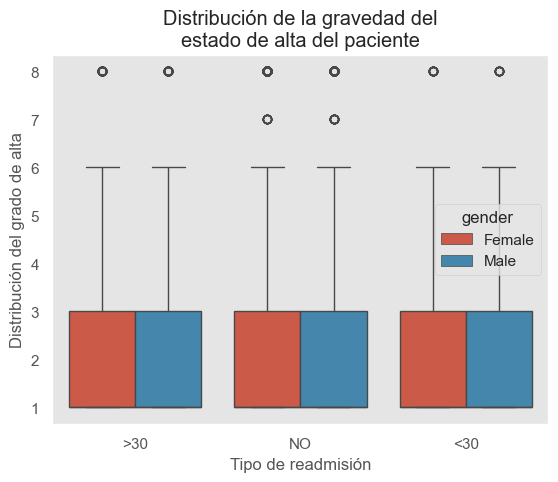

In [28]:
title = """Distribución de la gravedad del
estado de alta del paciente"""

sns.boxplot(data = df, x = 'readmitted', y = 'admission_type_id', hue = 'gender')
plt.title(title)
plt.ylabel("Distribución del grado de alta")
plt.xlabel('Tipo de readmisión')
plt.grid(False)
plt.show()

### Análisis del tipo diagnostico otorgado (los top 6)

In [10]:
df_diag = pd.read_csv(gen_path / 'data' / 'unique_diag_df_edit.csv', sep = ',')

In [11]:
dic_diag = {code : name for code, name in zip(df_diag['diagnosis_cd'], df_diag['diagnosis'])}

In [45]:
df["diag_1"].map(dic_diag).value_counts(ascending= False).head(6)

diag_1
CHF NOS                     6862
COR ATH UNSP VSL NTV/GFT    6580
RESPIRATORY ABNORM NOS      4015
AMI ANTEROLATERAL,UNSPEC    3614
PNEUMONIA, ORGANISM NOS     3506
PAROX ATRIAL TACHYCARDIA    2766
Name: count, dtype: int64

In [12]:
df["diag_2"].map(dic_diag).value_counts(ascending= False).head(6)

diag_2
HYPEROSMOLALITY             6694
CHF NOS                     6662
DIABETES MELLITUS           6069
PAROX ATRIAL TACHYCARDIA    5036
MALIGNANT HYPERTENSION      3736
CHR AIRWAY OBSTRUCT NEC     3305
Name: count, dtype: int64

In [47]:
df["diag_3"].map(dic_diag).value_counts(ascending= False).head(6)

diag_3
DIABETES MELLITUS           11554
MALIGNANT HYPERTENSION       8288
HYPEROSMOLALITY              5163
CHF NOS                      4577
PAROX ATRIAL TACHYCARDIA     3955
COR ATH UNSP VSL NTV/GFT     3664
Name: count, dtype: int64

### Análisis para el tipo de raza

In [13]:
df = df.loc[df["race"] != '?']

In [14]:
pd.crosstab(df["readmitted"], df['race'])

race,AfricanAmerican,Asian,Caucasian,Hispanic,Other
readmitted,,,,,
<30,2155,65,8589,212,145
>30,6629,161,27103,642,446
NO,10410,413,40271,1181,910


### Análisis para el tipo de seguro que tienen las personas

In [97]:
df_payer = df.loc[~df["payer_code"].isna()]
# df_payer = df.loc[df['payer_code'] != '?']

In [99]:
df_veces = pd.crosstab(df_payer["readmitted"], df_payer["payer_code"])

In [117]:
divisores = [4627, 13828, 21801]        # uno por fila
resultado = df_veces.iloc[:, 1:].rdiv(divisores, axis=0).round(3)

In [119]:
col_sums = resultado.sum()                 
top6_cols = col_sums.nlargest(6).index     
vista_top6 = resultado[top6_cols]         
print(pd.DataFrame(vista_top6))

payer_code       FR       SI       WC       MP       OT       CH
readmitted                                                      
<30             inf  661.000  925.400  514.111  661.000  355.923
>30             inf  813.412  576.167  354.564  363.895  419.030
NO          21801.0  703.258  205.670  703.258  436.020  218.010


### Análsis en el manejo de la diabetes

In [ ]:
df_max_glu = df.loc[~df['max_glu_serum'].isna()][['max_glu_serum', 'readmitted', 'A1Cresult']]

In [67]:
pd.crosstab(df_max_glu["readmitted"], df_max_glu["max_glu_serum"])

max_glu_serum,>200,>300,Norm
readmitted,,,
<30,184,179,292
>30,522,519,879
NO,760,555,1400


In [68]:
pd.crosstab(df_max_glu["readmitted"], df_max_glu['A1Cresult'])

A1Cresult,>7,>8,Norm
readmitted,,,
<30,8,19,8
>30,32,86,21
NO,23,69,26


### Análisis del tipo de insulina

In [69]:
pd.crosstab(df['readmitted'], df['insulin'])

insulin,Down,No,Steady,Up
readmitted,,,,
<30,1686,4690,3341,1449
>30,4698,15750,10265,4268
NO,5641,26028,16196,5320


### Análisis de cambios y si están tratando la enfermedad

In [70]:
pd.crosstab(df["readmitted"], df['change'])

change,Ch,No
readmitted,,
<30,5463,5703
>30,16975,18006
NO,23439,29746


In [71]:
pd.crosstab(df["readmitted"], df['diabetesMed'])

diabetesMed,No,Yes
readmitted,,
<30,2218,8948
>30,7144,27837
NO,13612,39573


In [72]:
pd.crosstab(df['readmitted'], df['gender'])

gender,Female,Male
readmitted,,
<30,6060,5106
>30,19244,15737
NO,28189,24996


## Análisis para las variables continuas

### Análsis del tiempo en el hospital

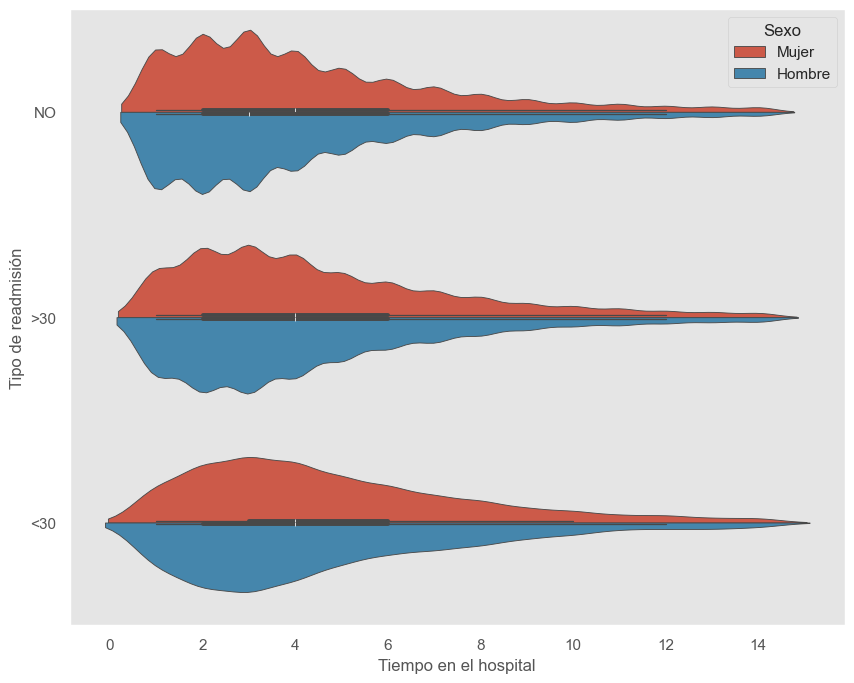

In [18]:
plt.figure(figsize= (10, 8))
ax = sns.violinplot(
    data=df,
    y='readmitted',
    x='time_in_hospital',
    hue='gender',
    split=True,
    fill=True
)

plt.xlabel('Tiempo en el hospital')
plt.ylabel('Tipo de readmisión')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Mujer', 'Hombre'], title='Sexo')
plt.grid(False)
plt.show()

### El tiempo promedio que las personas gastan en un hospital

In [19]:
df["time_in_hospital"].mean()

np.float64(4.396018199149003)

In [20]:
df["time_in_hospital"].max()

np.int64(14)

In [21]:
df["time_in_hospital"].min()

np.int64(1)

### Análisis del tipo que les toma estar en el hospital en relación al número de pruebas que se les realiza

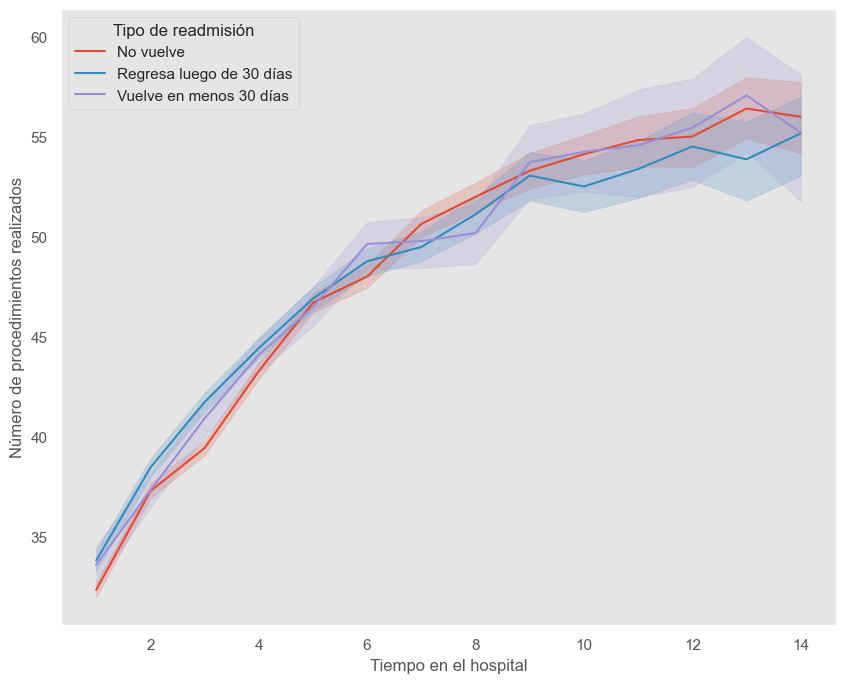

In [25]:
plt.figure(figsize= (10, 8))
ax = sns.lineplot(
    data=df,
    x='time_in_hospital',
    y='num_lab_procedures',
    hue='readmitted'
)

plt.xlabel('Tiempo en el hospital')
plt.ylabel('Número de procedimientos realizados')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No vuelve', 'Regresa luego de 30 días', 'Vuelve en menos 30 días'], title='Tipo de readmisión')
plt.grid(False)
plt.show()

### Análisis del tipo que les toma estar en el hospital en relación al número de medicamentos que se les otorga

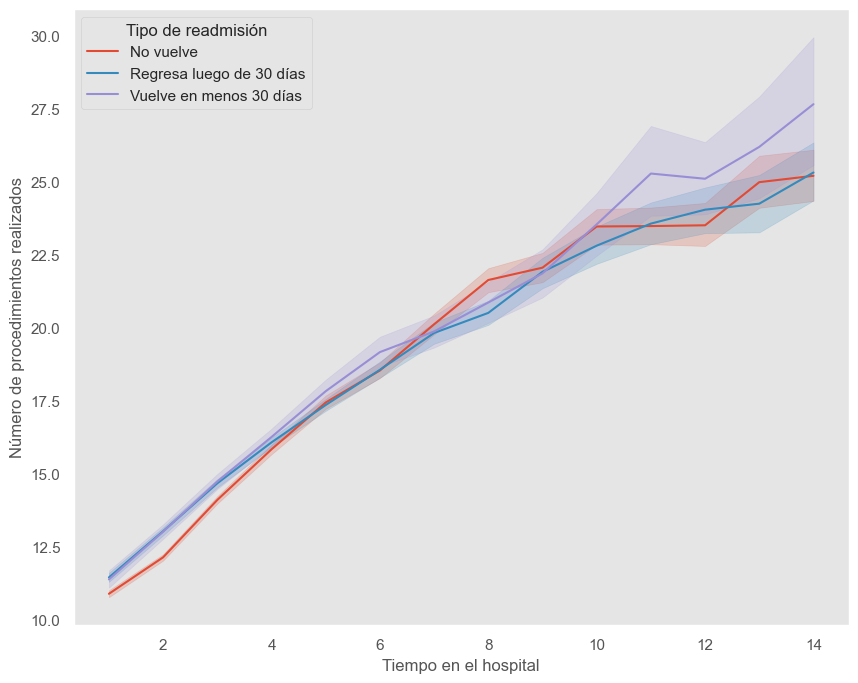

In [28]:
plt.figure(figsize= (10, 8))
ax = sns.lineplot(
    data=df,
    x='time_in_hospital',
    y='num_medications',
    hue='readmitted'
)

plt.xlabel('Tiempo en el hospital')
plt.ylabel('Número de procedimientos realizados')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No vuelve', 'Regresa luego de 30 días', 'Vuelve en menos 30 días'], title='Tipo de readmisión')
plt.grid(False)
plt.show()

### Complejidad del caso

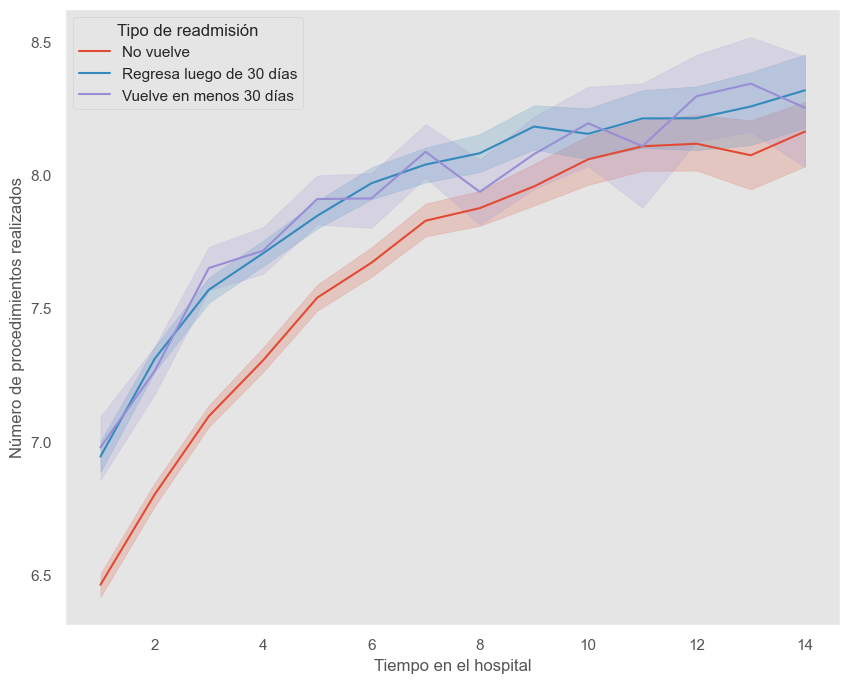

In [30]:
plt.figure(figsize= (10, 8))
ax = sns.lineplot(
    data=df,
    x='time_in_hospital',
    y='number_diagnoses',
    hue='readmitted'
)

plt.xlabel('Tiempo en el hospital')
plt.ylabel('Número de procedimientos realizados')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No vuelve', 'Regresa luego de 30 días', 'Vuelve en menos 30 días'], title='Tipo de readmisión')
plt.grid(False)
plt.show()

### Análisis dentro de cada grupo 

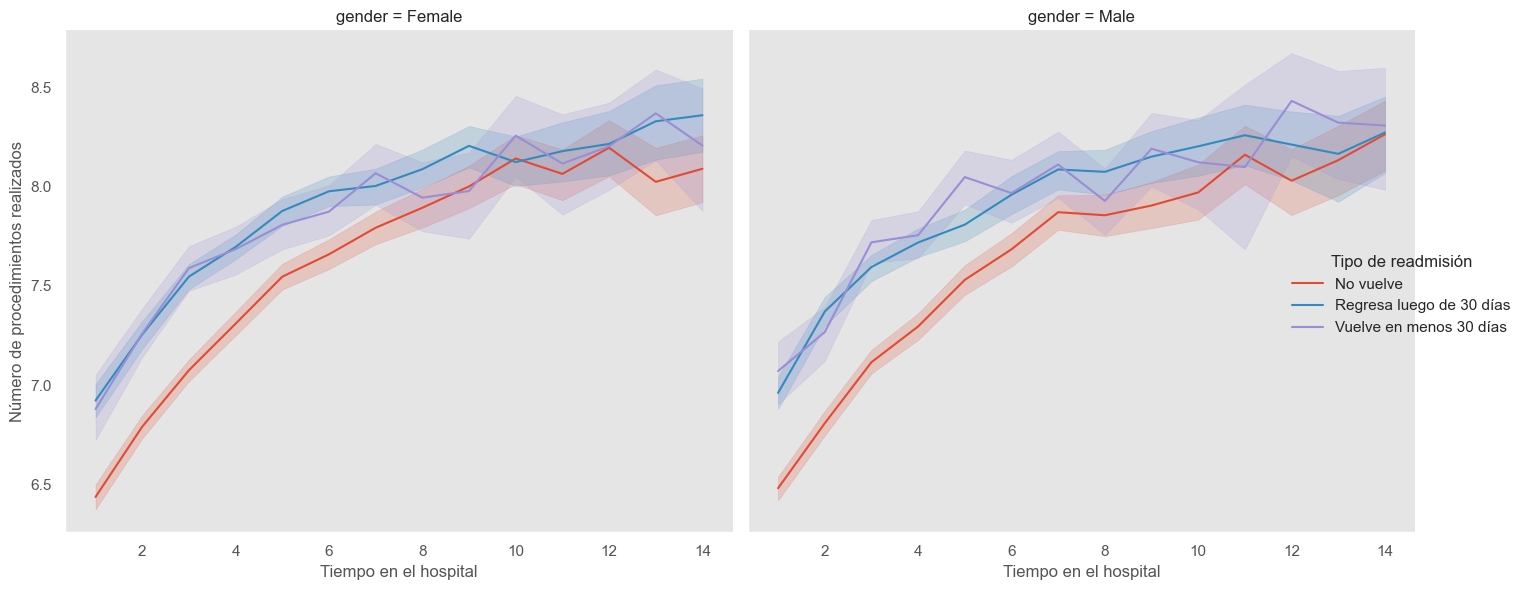

In [36]:
g = sns.relplot(
    data=df,
    x='time_in_hospital',
    y='number_diagnoses',
    hue='readmitted',
    col='gender',
    kind='line',
    height=6,
    aspect=1.2
)

g.set_axis_labels('Tiempo en el hospital', 'Número de procedimientos realizados')

new_labels = {
    'NO': 'No vuelve',
    '>30': 'Regresa luego de 30 días',
    '<30': 'Vuelve en menos 30 días'
}
for t, l in zip(g._legend.texts, g._legend.texts):
    t.set_text(new_labels.get(l.get_text(), l.get_text()))

g._legend.set_title('Tipo de readmisión')

for ax in g.axes.flatten():
    ax.grid(False)

plt.show()


##### Finaliza #####

En este caso no se observa alguna diferencia entre el tipo de readmisión, independientemente del genero, por tanto la variable 'mb_admission_type_ct' se va a eliminar de la base de datos.

In [56]:
df_test_cat = {
    'Variable_name' : [],
    'Chi2': [],
    'df' : [],
    'p_value' : []
}

In [57]:
# Realiza la verificación automatica de los casos que se encuentran en cada grupo,
# es caso no haya diferencias significativas se remueven del DF.

for col in df.select_dtypes("object").columns:
    tabla_test = pd.crosstab(df["readmitted"], df[col])

    chi2, p, dof, _ = chi2_contingency(tabla_test)

    df_test_cat['Variable_name'].append(col)
    df_test_cat['Chi2'].append(np.round(chi2, 4))
    df_test_cat['df'].append(dof)
    df_test_cat['p_value'].append(np.round(p, 4))

In [58]:
# En este caso no hay sufuciente evidencia estadística para rechazar la hipotesis nula que no hay relación entre las variables
df_test_cat = pd.DataFrame(df_test_cat)
df_test_cat.loc[df_test_cat["p_value"] >= 0.05]

,Variable_name,Chi2,df,p_value
13,nateglinide,3.4216,6,0.7544
14,chlorpropamide,8.9555,6,0.1761
16,acetohexamide,1.8630,2,0.3940
18,glyburide,10.0007,6,0.1246
19,tolbutamide,1.6352,2,0.4415
23,miglitol,11.5934,6,0.0717
24,troglitazone,1.4356,2,0.4878
25,tolazamide,5.0868,4,0.2785
26,examide,0.0000,0,1.0000
27,citoglipton,0.0000,0,1.0000


No hay suficiente evidencia estadística para rechazar la hipotesis nula que no hay asociación entre los factores, con un alpha de 0.05.

In [ ]:
drop.extend(["glyburide"])
df.drop(columns= drop, inplace= True)

In [ ]:
df.reset_index(inplace=True, drop= True)

In [ ]:
#  Guardo la información con el DF limpio
df.to_pickle(gen_path / 'data' / 'p004_diabetes_MLprep.pkl')

In [ ]:
# Eliminación del DFs sucios
del df, df_max_glu, df_payer, dic_diag

In [133]:
# El DF ya está limpio
# -> ########################################################### <-#
df = pd.read_pickle(gen_path / 'data' / 'p004_diabetes_MLprep.pkl')

df.drop(['encounter_id',	'patient_nbr'], axis = 1, inplace= True)
df.head()
# -> ########################################################### <-#

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,mb_num_procedures_ct,mb_num_medications_ct,mb_number_outpatient_ct,mb_number_emergency_ct,mb_number_inpatient_ct,mb_number_diagnoses_ct,mb A1c gt 7 ct,mb A1c gt 8 ct,mb A1c Norm ct,dummy
1,Female,[10-20),3,59,0,18,0,0,0,9,...,0,18,0,0,0,9,0,0,0,1
2,Female,[20-30),2,11,5,13,2,0,1,6,...,5,13,2,0,1,6,0,0,0,1
3,Male,[30-40),2,44,1,16,0,0,0,7,...,1,16,0,0,0,7,0,0,0,1
4,Male,[40-50),1,51,0,8,0,0,0,5,...,0,8,0,0,0,5,0,0,0,1
5,Male,[50-60),3,31,6,16,0,0,0,9,...,6,16,0,0,0,9,0,0,0,1


In [5]:
df.shape

(78743, 174)

In [134]:
col_age = np.array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'])
df["age"] = pd.Categorical(df["age"], categories= col_age, ordered= True)
df["age"] = df["age"].cat.codes

In [135]:
df.drop(["dummy"], axis = 1, inplace= True)

In [136]:
remove_col = [col for col in df.columns if col in ["readmitted_ind", "mb_readmitted_gt30_ct", "mb_readmitted_lt30_ct", "mb_readmitted_no_ct"]]

In [137]:
df.drop(remove_col, axis= 1, inplace= True)

In [8]:
df.shape

(78743, 169)

In [138]:
df.reset_index(inplace=True, drop= True)

Como se había observado previamente, no se cuenta con un número de salidas balanceado en el recuento de salidas posibles en el DF, por tal razón, se cuenta que estos pesos estratificados se tomarán en cuenta para asiganar la cantidad de observaciones.

In [139]:
split = StratifiedShuffleSplit(n_splits= 1, test_size= 0.2, random_state= 262025)

for ent_index, prueba_index in split.split(df, df["readmitted"]):
    df_train = df.loc[ent_index]
    df_test = df.loc[prueba_index]

In [13]:
df_train.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,mb_num_lab_procedures_ct,mb_num_procedures_ct,mb_num_medications_ct,mb_number_outpatient_ct,mb_number_emergency_ct,mb_number_inpatient_ct,mb_number_diagnoses_ct,mb A1c gt 7 ct,mb A1c gt 8 ct,mb A1c Norm ct
10949,Male,5,2,60,0,27,0,0,0,9,...,60,0,27,0,0,0,9,0,1,0
28124,Male,5,1,19,1,7,0,0,0,3,...,19,1,7,0,0,0,3,0,0,0
70732,Male,6,4,36,1,26,0,0,0,9,...,36,1,26,0,0,0,9,0,0,0
20147,Male,7,3,26,0,9,0,0,0,3,...,26,0,9,0,0,0,3,0,0,0
43850,Female,7,3,70,1,13,1,0,0,8,...,70,1,13,1,0,0,8,0,0,0


In [28]:
df_test.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,mb_num_lab_procedures_ct,mb_num_procedures_ct,mb_num_medications_ct,mb_number_outpatient_ct,mb_number_emergency_ct,mb_number_inpatient_ct,mb_number_diagnoses_ct,mb A1c gt 7 ct,mb A1c gt 8 ct,mb A1c Norm ct
6684,Female,3,5,46,0,7,0,0,0,4,...,46,0,7,0,0,0,4,0,0,0
724,Female,7,3,51,2,12,0,0,0,8,...,51,2,12,0,0,0,8,0,0,1
27601,Male,7,3,46,1,21,4,1,0,5,...,46,1,21,4,1,0,5,0,0,0
22447,Female,5,2,62,1,16,0,0,0,7,...,62,1,16,0,0,0,7,0,1,0
78481,Female,4,7,18,2,20,0,0,1,5,...,54,2,35,0,0,1,12,0,0,0


In [29]:
df_train.shape, df_test.shape

((62994, 169), (15749, 169))

## Cambiando las etiquetas de train y test de la variable objetivo

In [110]:
new_y_label = {
    'NO' : 0,
    '<30': 1,
    '>30': 2
}

return_y_label = {
    0 : 'NO',
    1 : '<30',
    2 : '>30'
}

In [101]:
numeric_features = df_train.select_dtypes('int64').columns
object_features = df_train.drop("readmitted", axis= 1).select_dtypes('object').columns

(X_train, y_train) = df_train.drop("readmitted", axis = 1), df_train["readmitted"]
(X_test, y_test) = df_test.drop("readmitted", axis = 1), df_test["readmitted"]

In [111]:
y_train = y_train.map(new_y_label)
y_test = y_test.map(new_y_label)

# Procesamiento de análisis de las variables que se encuentran en el DF

In [17]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ],
    remainder='passthrough'  # Deja pasar las columnas numéricas tal cual
)

Apartir de este punto estoy buscando el modelo que tenga el posible mejor redimiento, en este caso es para SoftMax.

In [36]:
softMax = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight = 'balanced',
                                  max_iter=1000,
                                  multi_class='multinomial',
                                  solver='lbfgs',
                                  random_state= 362025
                                  ))
    ])

In [37]:
# En el PipeLine se tiene que se ha guardado en el 'model',
# esto implica que se tiene que reemplazar con 'model__' en
# el gridSearch.
grid_softMax = [{
    "model__C": [0.01, 0.1, 1, 5, 10] # Los parámetros que se pueden aplicar para el ajuste de este posible modelo
    }]

grid_search_softMax = GridSearchCV(softMax, grid_softMax, cv = 5, scoring= 'f1_macro')

grid_search_softMax.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_procedures_ct', 'mb...
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='multinomial',
                                                           random_state=362025))]),
             param_grid=[{'model__C': [0.01, 0.1, 1, 5, 10]}],
             scoring='f1_macro')

In [38]:
grid_search_softMax.best_params_

{'model__C': 0.1}

## Módelo con SoftMax

El primero es el análisis del modelo de tipo multinomial.

In [47]:
# Este modelo se empieza ajustar con las mejores recomendaciones de los resultados
# otorgados del posible mejor modelo
softMax = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight = 'balanced',
                                  max_iter=1000,
                                  multi_class='multinomial',
                                  solver='lbfgs',
                                  C= 0.1,
                                  random_state= 362025
                                  ))
    ])

In [40]:
softMax.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_procedures_ct', 'mb_num_procedures_ct',
       'mb_num_...
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, multi_class='multinomial',
                                    random_state=362025))])

In [41]:
pred1 = softMax.predict(X_test)

In [42]:
confusion_matrix(y_test, pred1)

array([[7115,  486,  947],
       [ 373,  652,  678],
       [1860, 1189, 2449]])

In [44]:
f1_score(y_test, pred1, average= None)

array([0.79514975, 0.3235732 , 0.51170079])

In [45]:
precision_score(y_test, pred1, average= None)

array([0.76112537, 0.28018908, 0.60112911])

In [47]:
accuracy_score(y_test, pred1)

0.6486761064194552

In [48]:
# Guardando el modelo completo con todas las carácteristicas
joblib.dump(softMax, gen_path / 'models' / 'softMax_V003.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\softMax_V003.pkl']

In [102]:
#### Esta parte solo me sirve para cargar el modelo de donde lo tenía guardado ####
softMax_load = joblib.load(gen_path / 'models' / 'softMax_V003.pkl')
pred_softMax_eta1 = softMax_load.predict(X_test)

In [ ]:
# Revisando que el modelo haya convergido
softMax.named_steps["model"].n_iter_

array([299], dtype=int32)

## DecisionTreeClassifier

In [49]:
# Este no requiere preprocesador con estandirzación
tree_ = Pipeline(steps=[('preprocessor', preprocessor2),
                           ('model', DecisionTreeClassifier(random_state= 362025, 
                                                            class_weight= 'balanced'))])

grid_tree = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
}

In [50]:
grid_search_tree = GridSearchCV(tree_, grid_tree, cv = 3, scoring= 'f1_macro')
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                                       ('model',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=362025))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='f1_macro')

In [51]:
grid_search_tree.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 10,
 'model__min_samples_split': 2}

### Modelo Tree con mejor ajuste

In [57]:
# Aquí está el modelo con el mejor ajuste
tree_ = Pipeline(steps=[('preprocessor', preprocessor2),
                           ('model', DecisionTreeClassifier(random_state= 362025, 
                                                            class_weight= 'balanced',
                                                            criterion= 'gini',
                                                            max_depth= 10,
                                                            min_samples_split= 2))])

In [53]:
tree_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                                        random_state=362025))])

In [54]:
pred_tree = tree_.predict(X_test)

confusion_matrix(y_test, pred_tree)

array([[7289,  363,  896],
       [ 258, 1091,  354],
       [1540, 2085, 1873]])

In [55]:
joblib.dump(tree_, gen_path / 'models' / 'tree_V003.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\tree_V003.pkl']

In [103]:
tree_load = joblib.load(gen_path / 'models' / 'tree_V003.pkl')
tree_pred_eta1 = tree_load.predict(X_test)

## Random Forest

In [59]:
# Buscando la mejores opciones de hiperparametros
rf = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model', RandomForestClassifier(
    random_state=362025,
    class_weight= 'balanced',
    n_jobs= -1
    ))
])

grid_rf = {
    'model__n_estimators': [55, 100, 200],
    'model__max_depth': [6, 10, 15],
    'model__max_features': ['sqrt', 'log2']
}

In [66]:
grid_search_rf = GridSearchCV(rf, grid_rf, cv = 3, scoring= 'f1_macro')

In [67]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=362025))]),
             param_grid={'model__max_depth': [6, 10, 15],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__n_estimators': [55, 100, 200]},
             scoring='f1_macro')

In [68]:
grid_search_rf.best_params_

{'model__max_depth': 15,
 'model__max_features': 'sqrt',
 'model__n_estimators': 55}

In [60]:
# Este modelo es desarrollado con las mejores características
rf = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model', RandomForestClassifier(
    random_state= 362025,
    class_weight= 'balanced',
    max_depth= 15,
    max_features= 'sqrt',
    n_estimators= 55,
    n_jobs = -1
    ))
])

In [70]:
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        n_estimators=55, n_jobs=-1,
                                        random_state=362025))])

In [71]:
pred_rf = rf.predict(X_test)

confusion_matrix(y_test, pred_rf)

array([[6918,  979,  651],
       [ 362, 1074,  267],
       [1711, 2550, 1237]])

In [72]:
joblib.dump(rf, gen_path / 'models' / 'rf_V003.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\rf_V003.pkl']

In [104]:
rf_load = joblib.load(gen_path / 'models' / 'rf_V003.pkl')
pred_rf_eta1 = rf_load.predict(X_test)

# AdaBoost

In [18]:
# Buscando las mejores opciones de hiperparametros para XGBoost
adaB = Pipeline(steps=[
        ('preprocessor', preprocessor2),
            ('model', AdaBoostClassifier(
                estimator=DecisionTreeClassifier(
                    random_state=362025, 
                    class_weight='balanced',
                    criterion='gini',
                    max_depth=10,
                    min_samples_split=2
                ),
                learning_rate=0.1,
                n_estimators=100,
                random_state=362025
            ))
])

param_grid_adaB = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.5, 0.1]
}

In [ ]:
grid_search_adaB = GridSearchCV(adaB, param_grid_adaB, cv = 3, scoring= 'f1_macro', n_jobs=-1, verbose=True)

grid_search_adaB.fit(X_train, y_train)

In [ ]:
df_adaB = pd.DataFrame(grid_search_adaB.cv_results_)

df_adaB

In [ ]:
grid_search_adaB.best_estimator_

In [ ]:
grid_search_adaB.best_params_

In [20]:
# Modelo ajustado con los mejores hiperparametros

adaB = Pipeline(steps=[
        ('preprocessor', preprocessor2),
            ('model', AdaBoostClassifier(
                estimator=DecisionTreeClassifier(
                    random_state=362025, 
                    class_weight='balanced',
                    criterion='gini',
                    max_depth=10,
                    min_samples_split=2
                ),
                learning_rate=0.1,
                n_estimators=100,
                random_state=362025
            ))
])

In [21]:
adaB.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=10,
                                                                     random_state=362025),
                                    learning_rate=0.1, n_estimators=100,
                                    random_state=362025))])

In [22]:
pred_adaB = adaB.predict(X_test)

In [23]:
pred_adaB = pd.Series(pred_adaB)

pred_adaB = pred_adaB.map({
   0 : 'NO',
   1 : '<30',
   2 : '>30'
})

y_test = y_test.map(return_y_label)

In [24]:
confusion_matrix(y_test, pred_adaB)

array([[1031,  390,  282],
       [1772, 2142, 1584],
       [ 183,  882, 7483]])

In [25]:
joblib.dump(adaB, gen_path / 'models' / 'adaB_V002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\adaB_V002.pkl']

In [105]:
adaB_load = joblib.load(gen_path / 'models' / 'adaB_V002.pkl')
pred_adaB_eta1 = adaB_load.predict(X_test)

# Comparación de todos los modelos en comparación de análisis

In [26]:
# Función para análizar mi accuracy y recall
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 

## Análisis solo para SoftMax

In [51]:
pred_softMax = softMax_load.predict(X_test)
cm_softMax = confusion_matrix(y_test, pred_softMax)

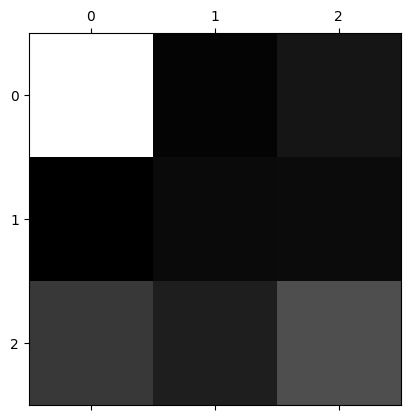

In [38]:
plt.matshow(cm_softMax, cmap=plt.cm.gray)
plt.grid(False)
plt.show()

In [39]:
acc_softMax = accuracy_score(y_test, pred_softMax)
acc_softMax

0.6486761064194552

In [40]:
preci_soft = precision_score(y_test, pred_softMax, average= None)
preci_soft

array([0.76112537, 0.28018908, 0.60112911])

In [41]:
preci_macro_soft = precision_score(y_test, pred_softMax, average= 'macro')
preci_macro_soft

0.5474811901694623

In [42]:
preci_micro_soft = precision_score(y_test, pred_softMax, average= 'weighted')
preci_micro_soft

0.6532649416681783

In [43]:
f1_soft = f1_score(y_test, pred_softMax, average= None)
f1_soft

array([0.79514975, 0.3235732 , 0.51170079])

In [44]:
class_ = np.unique(y_train)

In [45]:
y_train_bin = label_binarize(y_train, classes=class_)

In [ ]:
y_probas = cross_val_predict(softMax, X_train, y_train, cv=5, method= 'predict')

plt.figure(figsize=(8, 6))
for i, clase in enumerate(class_):
    precision, recall, _ = precision_recall_curve(y_train_bin[:, i], y_probas[:, i])
    ap = average_precision_score(y_train_bin[:, i], y_probas[:, i])
    plt.plot(recall, precision, label=f'Clase: {clase} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall por clase')
plt.legend()
plt.grid(False)
plt.ylim((0, 1))
plt.tight_layout()
plt.show()

In [102]:
# Análisis para las curvas de ROC
def roc_curve_multiclass(mod, X_train = None, y_train = None, cv = None, figsize= (10, 8)):
    # Tomar parámetros únicos
    classes = np.unique(y_train)
    n_classes = len(classes)

    # Cambiando la composición de los valores de 'y_train'
    y_train_bin = label_binarize(y_train, classes=classes)

    # Obtener probabilidades con validación cruzada
    y_probas = cross_val_predict(
        mod,
        X_train,
        y_train,
        cv= cv,
        method= "predict_proba"
    )

    # Calcular fpr, tpr, auc para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_train_bin.ravel(), y_probas.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize= figsize)

    # Macro y Micro primero
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
            color='navy', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'Clase: {classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curvas ROC para Clasificación Multiclase')
    plt.legend(loc="lower right")
    plt.grid(False)


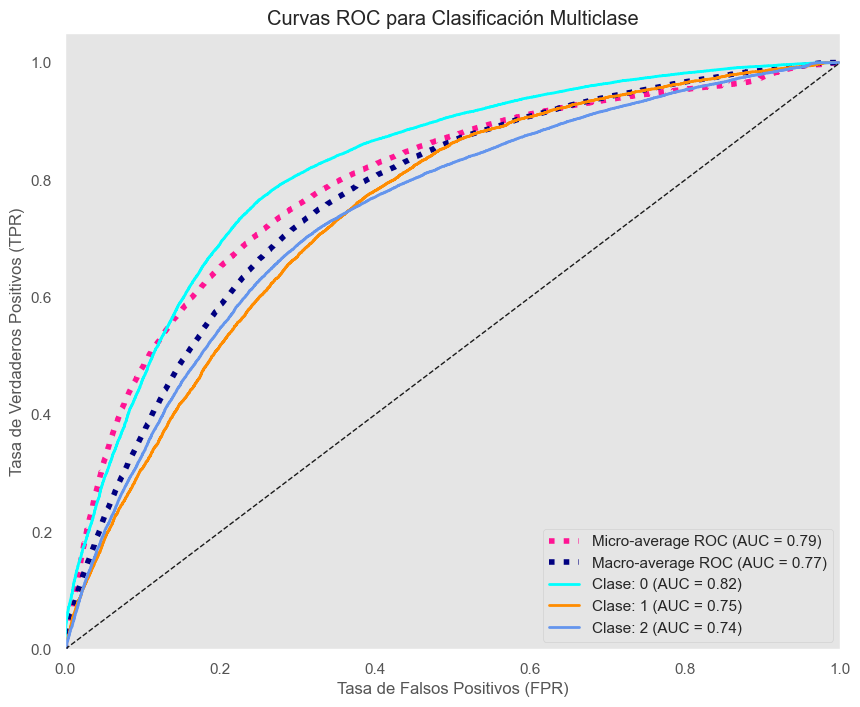

In [103]:
roc_curve_multiclass(softMax, X_train, y_train, cv = 5)

## Análisis solo para un Árbol

In [ ]:
cm_tree = confusion_matrix(y_test, tree_load.predict(X_test))

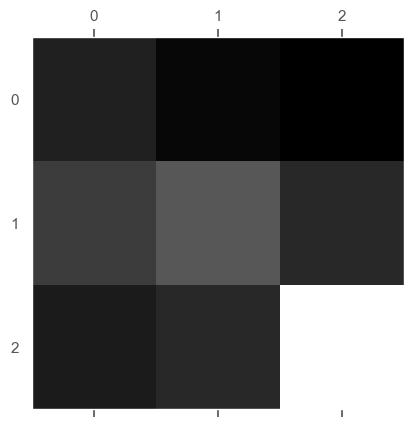

In [105]:
plt.matshow(cm_tree, cmap=plt.cm.gray)
plt.grid(False)
plt.show()

In [107]:
acc_tree = accuracy_score(y_test, tree_pred)
acc_tree

0.6326723920181864

In [108]:
preci_tree = precision_score(y_test, tree_pred, average= None)
preci_tree

array([0.27785271, 0.59138991, 0.81659226])

In [109]:
preci_macro_tree = precision_score(y_test, tree_pred, average= 'macro')
preci_macro_tree

0.5619449622970111

In [110]:
preci_micro_tree = precision_score(y_test, tree_pred, average= 'micro')
preci_macro_tree

0.5619449622970111

In [112]:
f1_tree = f1_score(y_test, tree_pred, average= None)
f1_tree

array([0.38261516, 0.50738708, 0.78336902])

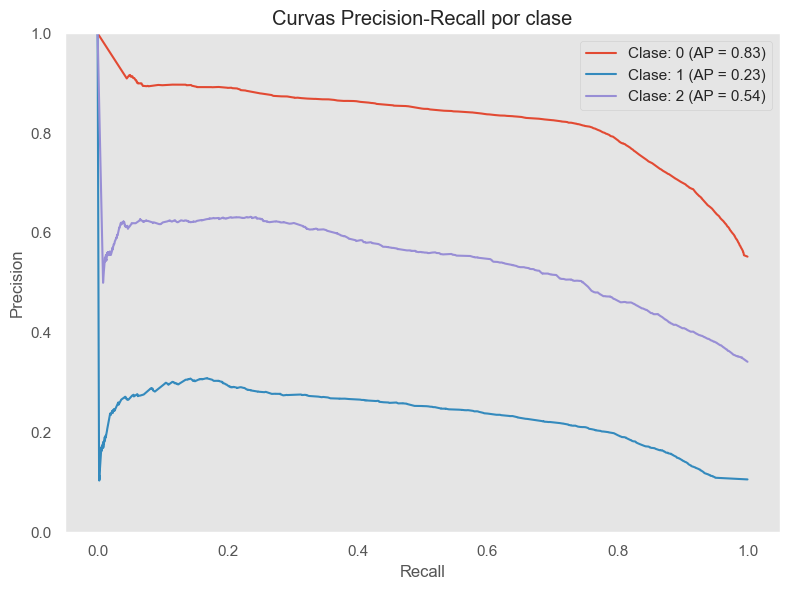

In [114]:
y_probas = cross_val_predict(tree_, X_train, y_train, cv=5, method= "predict_proba")

plt.figure(figsize=(8, 6))
for i, clase in enumerate(class_):
    precision, recall, _ = precision_recall_curve(y_train_bin[:, i], y_probas[:, i])
    ap = average_precision_score(y_train_bin[:, i], y_probas[:, i])
    plt.plot(recall, precision, label=f'Clase: {clase} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall por clase')
plt.legend()
plt.grid(False)
plt.ylim((0, 1))
plt.tight_layout()
plt.show()

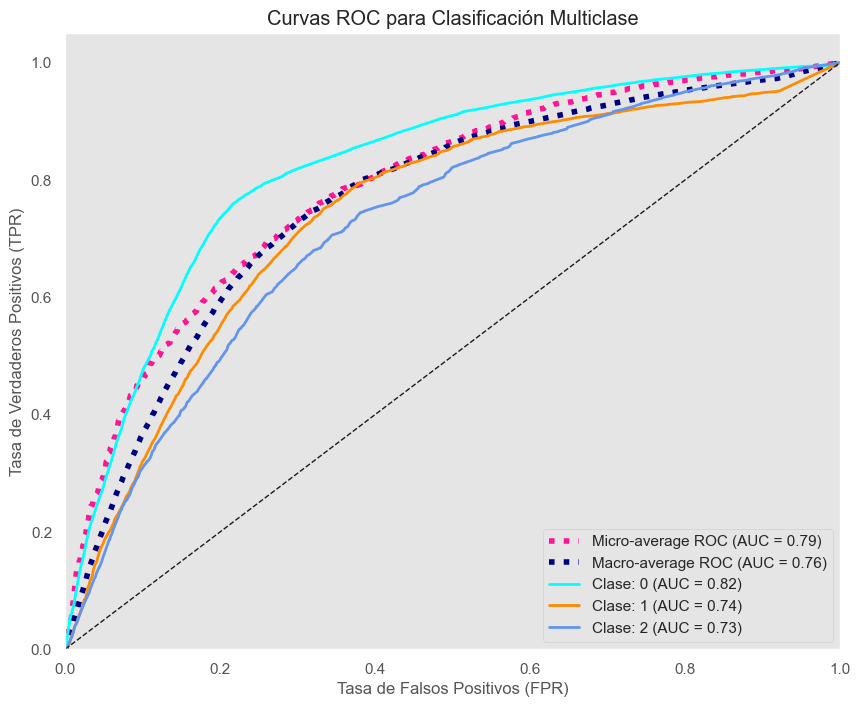

In [115]:
roc_curve_multiclass(tree_, X_train, y_train, cv = 5)

## Análisis para RandomForest

In [17]:
rf_pred =  rf_load.predict(X_test)
cm_rf = confusion_matrix(y_test, rf_pred)

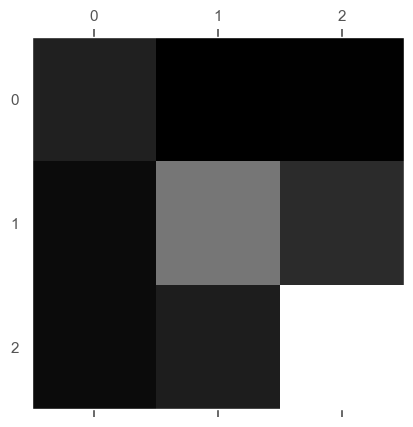

In [117]:
plt.matshow(cm_rf, cmap=plt.cm.gray)
plt.grid(False)
plt.show()

In [118]:
acc_rf = accuracy_score(y_test, rf_pred)
acc_rf

0.7418540035362465

In [119]:
preci_rf = precision_score(y_test, rf_pred, average= None)
preci_rf

array([0.51205357, 0.72652632, 0.80827493])

In [120]:
preci_macro_rf = precision_score(y_test, rf_pred, average= 'macro')
preci_macro_rf

0.6822849379128355

In [121]:
preci_micro_rf = precision_score(y_test, rf_pred, average= 'micro')
preci_micro_rf

0.7418540035362465

In [122]:
f1_rf = f1_score(y_test, rf_pred, average= None)
f1_rf

array([0.58565228, 0.67926385, 0.81277708])

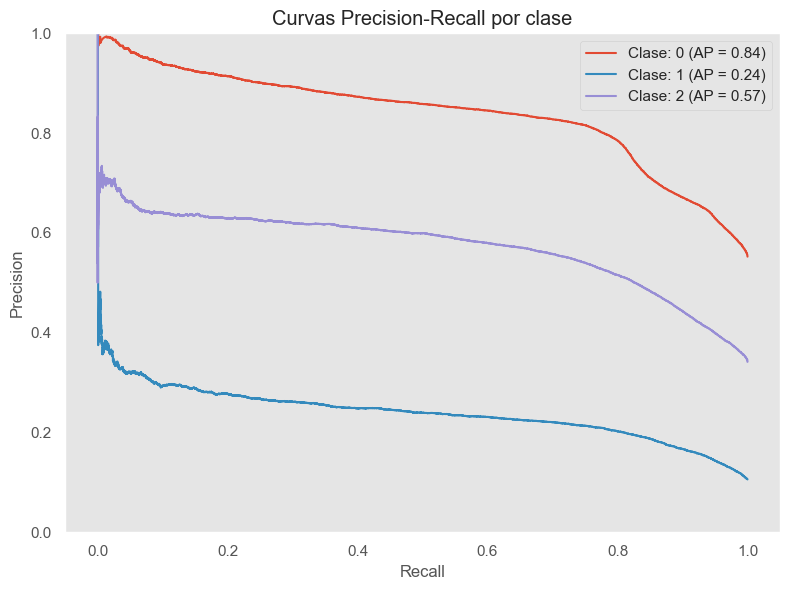

In [124]:
y_probas = cross_val_predict(rf, X_train, y_train, cv=5, method= "predict_proba")

plt.figure(figsize=(8, 6))
for i, clase in enumerate(class_):
    precision, recall, _ = precision_recall_curve(y_train_bin[:, i], y_probas[:, i])
    ap = average_precision_score(y_train_bin[:, i], y_probas[:, i])
    plt.plot(recall, precision, label=f'Clase: {clase} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall por clase')
plt.legend()
plt.grid(False)
plt.ylim((0, 1))
plt.tight_layout()
plt.show()

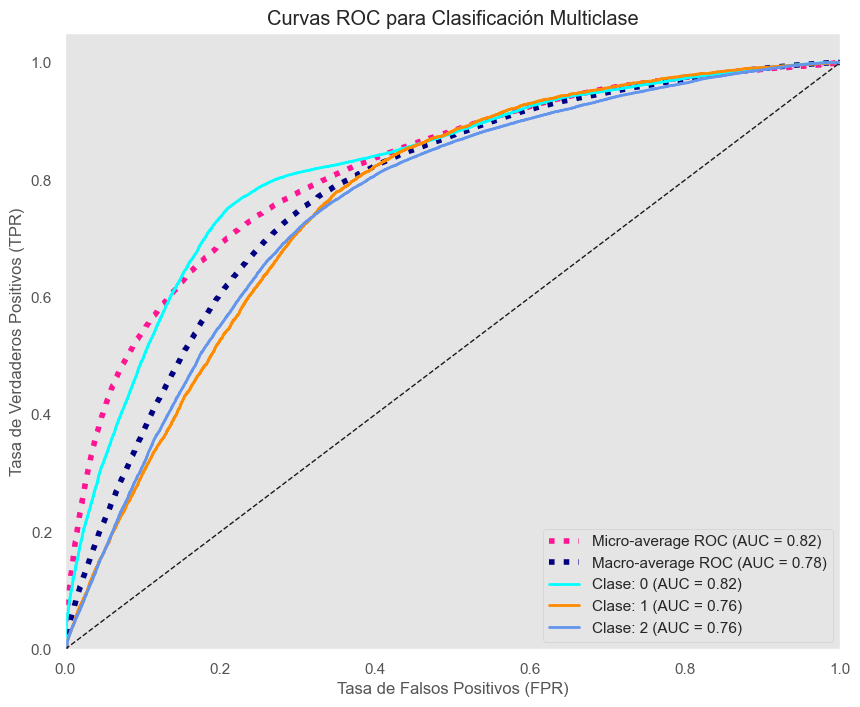

In [125]:
roc_curve_multiclass(rf, X_train, y_train, cv = 5)

## Análisis solo para AdaBoost

In [18]:
adaB_pred = adaB_load.predict(X_test)

In [137]:
y_test = y_test.map(new_y_label)

In [ ]:
cm_adaB = confusion_matrix(y_test, adaB_pred)

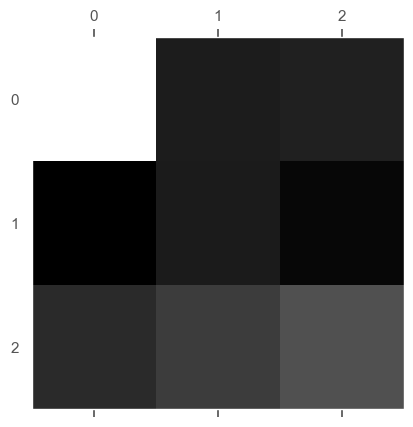

In [133]:
plt.matshow(cm_adaB, cmap=plt.cm.gray)
plt.grid(False)
plt.show()

In [138]:
acc_adaB = accuracy_score(y_test, adaB_pred)
acc_adaB

0.6254736044455671

In [ ]:
preci_adaB = precision_score(y_test, adaB_pred, average= None)
preci_adaB

In [140]:
preci_micro_adaB = precision_score(y_test, adaB_pred, average= 'micro')
preci_micro_adaB

0.6254736044455671

In [141]:
f1_adaB = f1_score(y_test, adaB_pred, average= None)
f1_adaB

array([0.78373774, 0.3518278 , 0.49384582])

# Análisis de sobre ajuste de un modelo para categorías especificas

In [159]:
model_testing_men30 = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model',
    CatBoostClassifier(
    iterations= 100, 
    learning_rate= 0.05,
    class_weights= [1, 5, 1],
    verbose= 0,
    random_state= 362025
))
])

In [ ]:
model_testing_men30.fit(X_train, y_train)

In [ ]:
pred_testing = model_testing_men30.predict(X_test).squeeze()

In [ ]:
confusion_matrix(y_test, pred_testing)

# Stacking

Último modelo desarrollado con Stacking:

In [55]:
modelos = {
    "SoftMax" : pred_softMax_eta1,
    'Arbol de decisión' : tree_pred_eta1,
    'Random Forest' : pred_rf_eta1,
    'AdaBoost' : pred_adaB_eta1
}
for nombre, pred_mod in modelos.items():
    scores = np.mean(f1_score(y_test, pred_mod, average= None))
    accu = np.mean(accuracy_score(y_test, pred_mod))
    prec = np.mean(precision_score(y_test, pred_mod, average= None))
    print(f"{nombre}: F1 CV score = {scores:.4f} | accuracy : {accu:.4f} | precision : {prec:.4f}" )

SoftMax: F1 CV score = 0.5435 | accuracy : 0.6487 | precision : 0.5475
Arbol de decisión: F1 CV score = 0.5591 | accuracy : 0.6510 | precision : 0.5701
Random Forest: F1 CV score = 0.4843 | accuracy : 0.5860 | precision : 0.5256
AdaBoost: F1 CV score = 0.5856 | accuracy : 0.6766 | precision : 0.5910


# Cambiando escenarios

In [61]:
stacking = StackingClassifier(
    estimators=[
        ("softMax", softMax),
        ("only_one_tree", tree_),
        ("random_forest", rf)
    ],
        final_estimator=  AdaBoostClassifier(
                estimator=DecisionTreeClassifier(
                    random_state=362025, 
                    class_weight='balanced',
                    criterion='gini',
                    max_depth=10,
                    min_samples_split=2,
                ),
                learning_rate=0.1,
                n_estimators=100,
                random_state=362025
            ),
    n_jobs= -1
)

In [62]:
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('softMax',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  StandardScaler(),
                                                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_proc...
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                                                ('model',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=15,
                                                                        n_estimators=55,
                                                                        n_jobs=-1,
                                                                        random_state=362025))]))],
                   final_estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                       max_depth=10,
                                                                                       random_state=362025),
                                                      learning_rate=0.1,
                                                      n_estimators=100,
                                                      random_state=362025),
                   n_jobs=-1)

In [63]:
joblib.dump(stacking, gen_path / 'models' / 'stacking_V007.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\stacking_V007.pkl']

In [106]:
# Cargar el modelo previamente entrenado
stacking_load = joblib.load(gen_path / 'models' / 'stacking_V007.pkl')

In [107]:
pred_stacking_eta1 = stacking_load.predict(X_test)

In [70]:
cm_stacking = confusion_matrix(y_test, pred_stacking_eta1)
cm_stacking

array([[7459,  222,  867],
       [ 284,  944,  475],
       [1622, 1754, 2122]])

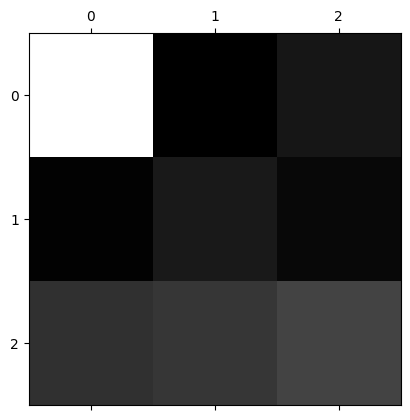

In [71]:
plt.matshow(cm_stacking, cmap = plt.cm.gray)
plt.grid(False)
plt.show()

In [72]:
acc_stacking = accuracy_score(y_test, pred_stacking_eta1)
acc_stacking

0.6682963997714141

In [73]:
preci_stacking = precision_score(y_test, pred_stacking_eta1, average= None)
preci_stacking

array([0.79647624, 0.32328767, 0.61258661])

In [120]:
np.mean([0.79647624, 0.32328767, 0.61258661])

np.float64(0.5774501733333334)

In [74]:
preci_macro_stacking = precision_score(y_test, pred_stacking_eta1, average= 'macro')
preci_macro_stacking


0.577450172545929

In [75]:
preci_micro_stacking = precision_score(y_test, pred_stacking_eta1, average= 'weighted')
preci_micro_stacking

0.6811123861630723

In [76]:
f1_stacking = f1_score(y_test, pred_stacking_eta1, average= None)
f1_stacking

array([0.83280299, 0.40839282, 0.47355501])

In [121]:
np.mean([0.83280299, 0.40839282, 0.47355501])

np.float64(0.5715836066666666)

## Analizando todos los modelos juntos

In [77]:
modelos = {
    "SoftMax" : pred_softMax_eta1,
    'Arbol de decisión' : tree_pred_eta1,
    'Random Forest' : pred_rf_eta1,
    'AdaBoost' : pred_adaB_eta1,
    'Stacking' : pred_stacking_eta1
}
for nombre, pred_mod in modelos.items():
    scores = np.mean(f1_score(y_test, pred_mod, average= None))
    accu = np.mean(accuracy_score(y_test, pred_mod))
    prec = np.mean(precision_score(y_test, pred_mod, average= None))
    print(f"{nombre}: F1 CV score = {scores:.4f} | accuracy : {accu:.4f} | precision : {prec:.4f}" )

SoftMax: F1 CV score = 0.5435 | accuracy : 0.6487 | precision : 0.5475
Arbol de decisión: F1 CV score = 0.5591 | accuracy : 0.6510 | precision : 0.5701
Random Forest: F1 CV score = 0.4843 | accuracy : 0.5860 | precision : 0.5256
AdaBoost: F1 CV score = 0.5856 | accuracy : 0.6766 | precision : 0.5910
Stacking: F1 CV score = 0.5716 | accuracy : 0.6683 | precision : 0.5775


In [85]:
pred_tot = adaB_load.predict(df.drop("readmitted", axis = 1))
pred_tot = pd.Series(pred_tot).map(return_y_label)

In [84]:
confusion_matrix(df["readmitted"], pd.Series(pred_tot).map(return_y_label))

array([[ 6238,  1008,  1270],
       [ 8000, 11846,  7641],
       [  887,  4094, 37759]])

In [86]:
aciertos = df["readmitted"] == pred_tot

n_aciertos = np.sum(aciertos)
n_errores = len(aciertos) - n_aciertos

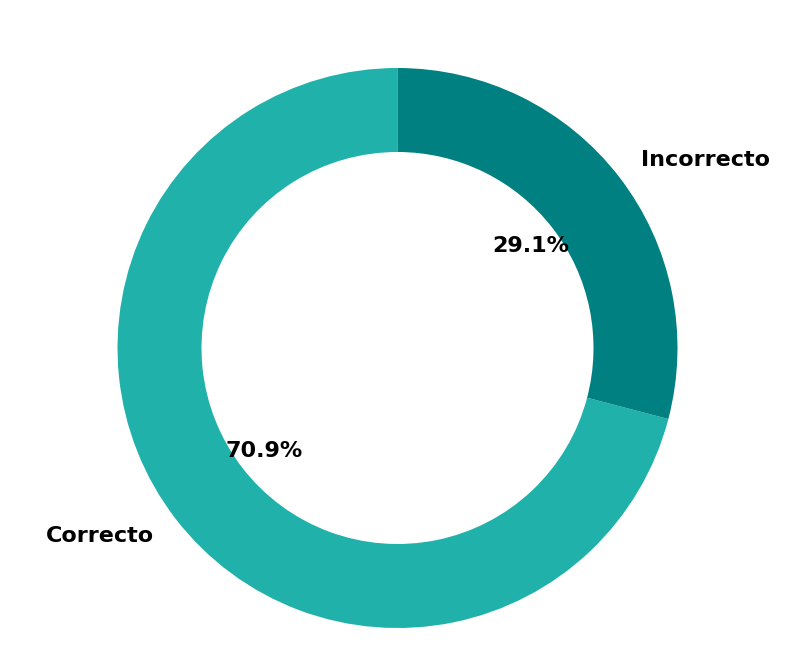

In [87]:
aciertos = df["readmitted"] == pred_tot

n_aciertos = np.sum(aciertos)
n_errores = len(aciertos) - n_aciertos

sizes = [n_aciertos, n_errores]
labels = ['Correcto', 'Incorrecto']
colors = ['#20B2AA', '#008080']

fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90,
    colors=colors,
    wedgeprops={'width':0.3}
)

for text in texts:
    text.set_fontsize(16)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(16)
    autotext.set_fontweight('bold')

ax.axis('equal')
plt.title(' ', fontsize=20, fontweight='bold')
plt.show()


***

# Análisis de un modelo jerarquico

El siguiente modelo toma en cuenta cómo se conforman diferentes estructuras de jerarquía de modelos, esto es por el motivo de un problema muy serio en el desvalance de las observaciones en cada una de las categorías.

In [10]:
# Reconfiguración de la variable 
return_y_label_step_1 = {
    1 : '>30 o <30',
    0 : 'No'
}

In [11]:
df_step_1 = df.copy()
df_step_1["readmitted_1"] = np.where(
    (df_step_1["readmitted"] == "<30") | (df_step_1["readmitted"] == ">30"), 1, 0
)

df_step_1.drop("readmitted", axis = 1, inplace= True)

# Paso 2: Dividir con StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=262025)

for ent_index, prueba_index in split.split(df_step_1, df_step_1["readmitted_1"]):
    df_train = df_step_1.loc[ent_index]
    df_test = df_step_1.loc[prueba_index]

print("El split en el DF está listo")

El split en el DF está listo


In [12]:
numeric_features = df_train.drop("readmitted_1", axis = 1).select_dtypes(include="int64").columns
object_features = df_train.drop(["readmitted_1"], axis=1).select_dtypes(include="object").columns

In [13]:
(X_train, y_train) = df_train.drop("readmitted_1", axis = 1), df_train["readmitted_1"]
(X_test, y_test) = df_test.drop("readmitted_1", axis = 1), df_test["readmitted_1"]

In [92]:
X_train.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,mb_num_lab_procedures_ct,mb_num_procedures_ct,mb_num_medications_ct,mb_number_outpatient_ct,mb_number_emergency_ct,mb_number_inpatient_ct,mb_number_diagnoses_ct,mb A1c gt 7 ct,mb A1c gt 8 ct,mb A1c Norm ct
63576,Female,7,4,44,3,24,2,1,0,9,...,45,3,36,3,2,0,16,0,0,0
10742,Female,5,12,59,0,18,0,0,1,9,...,173,1,40,0,0,2,27,0,0,0
31644,Female,6,8,59,2,32,4,0,0,9,...,59,2,32,4,0,0,9,0,0,0
53623,Male,7,5,36,1,27,0,0,0,9,...,36,1,27,0,0,0,9,0,0,0
67526,Male,7,3,62,1,39,0,0,1,9,...,120,2,61,0,0,1,18,0,0,0


In [93]:
X_test.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,mb_num_lab_procedures_ct,mb_num_procedures_ct,mb_num_medications_ct,mb_number_outpatient_ct,mb_number_emergency_ct,mb_number_inpatient_ct,mb_number_diagnoses_ct,mb A1c gt 7 ct,mb A1c gt 8 ct,mb A1c Norm ct
15982,Male,6,6,47,0,13,0,0,1,8,...,47,0,13,0,0,1,8,0,0,0
64270,Male,5,1,2,3,11,0,0,0,6,...,35,3,18,1,0,1,15,0,0,0
30024,Female,7,8,41,1,11,0,1,0,8,...,87,2,42,0,1,2,16,0,0,0
23029,Female,6,3,43,0,14,0,0,0,4,...,43,0,14,0,0,0,4,0,0,0
45499,Female,5,4,39,0,20,3,0,0,9,...,39,0,20,3,0,0,9,0,0,0


In [94]:
# En este caso se observa que los datos están mayormente balanceados
Counter(y_train)

Counter({0: 34192, 1: 28802})

***

## Análisis del primer caso

In [95]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ],
    remainder='passthrough'  # Deja pasar las columnas numéricas tal cual
)

## Análisis de SoftMax

In [96]:
softMax_step_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight = 'balanced',
                                  max_iter= 1000,
                                  solver= 'lbfgs',
                                  random_state= 362025
                                  ))
    ])

In [97]:
%%time
grid_softMax = [{
    "model__C": [0.01, 0.1, 1, 5, 10] # Los parámetros que se pueden aplicar para el ajuste de este posible modelo
    }]

grid_search_softMax = GridSearchCV(softMax_step_1, grid_softMax, cv = 3, scoring= 'f1')

grid_search_softMax.fit(X_train, y_train)

CPU times: total: 2min 4s
Wall time: 2min 17s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_procedures_ct', 'mb...
                                                                         Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=362025))]),
             param_grid=[{'model__C': [0.01, 0.1, 1, 5, 10]}], scoring='f1')

In [98]:
grid_search_softMax.best_params_

{'model__C': 0.1}

## Módelo con SoftMax

El primero es el análisis del modelo de tipo binomial.

In [99]:
softMax = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight = 'balanced',
                                  max_iter=1000,
                                  solver='lbfgs',
                                  C= 0.1,
                                  random_state= 362025
                                  ))
    ])

In [100]:
softMax.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_procedures_ct', 'mb_num_procedures_ct',
       'mb_num_...
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, random_state=362025))])

In [101]:
pred1 = softMax.predict(X_test)

In [102]:
confusion_matrix(y_test, pred1)

array([[7307, 1241],
       [2359, 4842]])

In [103]:
f1_score(y_test, pred1)

0.7289972899728997

In [104]:
accuracy_score(y_test, pred1)

0.7714140580354308

In [105]:
precision_score(y_test, pred1)

0.795988821305277

In [106]:
# Guardando el modelo completo con todas las carácteristicas
joblib.dump(softMax, gen_path / 'models' / 'softMax_eta1__T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\softMax_eta1__T002.pkl']

In [109]:
#### Esta parte solo me sirve para cargar el modelo de donde lo tenía guardado ####
softMax_load = joblib.load(gen_path / 'models' / 'softMax_eta1__T002.pkl')

In [110]:
pred_softMax_eta1 = softMax_load.predict(X_test)

## Decision Tree Classifier

In [111]:
# Este no requiere preprocesador con estandirzación
tree_ = Pipeline(steps=[('preprocessor', preprocessor2),
                           ('model', DecisionTreeClassifier(random_state= 362025, 
                                                            class_weight= 'balanced'))])

grid_tree = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
}

In [114]:
grid_search_tree = GridSearchCV(tree_, grid_tree, cv = 5, scoring= 'f1', n_jobs = -1)
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                                       ('model',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=362025))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 5, 10, 20],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='f1')

In [115]:
grid_search_tree.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 5,
 'model__min_samples_split': 2}

### Modelo Tree con mejor ajuste

In [116]:
# Aquí está el modelo con el mejor ajuste
tree_ = Pipeline(steps=[('preprocessor', preprocessor2),
                           ('model', DecisionTreeClassifier(random_state= 362025, 
                                                            class_weight= 'balanced',
                                                            criterion= 'gini',
                                                            max_depth= 5,
                                                            min_samples_split= 2))])

In [117]:
%%time
tree_.fit(X_train, y_train)

CPU times: total: 3.75 s
Wall time: 3.88 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        random_state=362025))])

In [118]:
pred_tree = tree_.predict(X_test)

confusion_matrix(y_test, pred_tree)

array([[7652,  896],
       [1983, 5218]])

In [119]:
joblib.dump(tree_, gen_path / 'models' / 'tree_eta1__T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\tree_eta1__T002.pkl']

In [120]:
tree_load = joblib.load(gen_path / 'models' / 'tree_eta1__T002.pkl')

In [121]:
pred_tree_eta1 = tree_load.predict(X_test)

In [122]:
precision_score(y_test, pred_tree)

0.8534510958456003

In [123]:
accuracy_score(y_test, pred_tree)

0.8171947425233348

In [124]:
f1_score(y_test, pred_tree)

0.7837776943297033

## Random Forest

In [125]:
# Buscando la mejores opciones de hiperparametros
rf = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model', RandomForestClassifier(
    random_state=362025,
    class_weight= 'balanced',
    n_jobs= -1
    ))
])

grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [6, 10, 20],
    'model__max_features': ['sqrt', 'log2']
}

In [126]:
grid_search_rf = GridSearchCV(rf, grid_rf, cv = 5, scoring= 'f1')

In [127]:
%%time
grid_search_rf.fit(X_train, y_train)

CPU times: total: 8min 7s
Wall time: 2min 19s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=362025))]),
             param_grid={'model__max_depth': [6, 10, 20],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__n_estimators': [50, 100, 200]},
             scoring='f1')

In [128]:
grid_search_rf.best_params_

{'model__max_depth': 20,
 'model__max_features': 'sqrt',
 'model__n_estimators': 100}

### Mejor modelo desarrollado con Random Forest

In [129]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model', RandomForestClassifier(
    random_state= 362025,
    class_weight= 'balanced',
    max_depth= 20,
    max_features= 'sqrt',
    n_estimators= 300,
    n_jobs= -1
    ))
])

In [131]:
%%time
rf.fit(X_train, y_train)

CPU times: total: 44.7 s
Wall time: 7.32 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=362025))])

In [132]:
pred_rf = rf.predict(X_test)

confusion_matrix(y_test, pred_rf)

array([[6842, 1706],
       [1949, 5252]])

In [133]:
joblib.dump(rf, gen_path / 'models' / 'rf_eta1__T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\rf_eta1__T002.pkl']

In [136]:
rf_load = joblib.load(gen_path / 'models' / 'rf_eta1__T002.pkl')

In [137]:
pred_rf_eta1 = rf_load.predict(X_test)

In [138]:
f1_score(y_test, pred_rf)

0.7418603008687055

In [139]:
precision_score(y_test, pred_rf)

0.7548146018970968

In [140]:
accuracy_score(y_test, pred_rf)

0.7679217728109721

### Análisis para XGBoost

1. Primera etapa del entrenamiento

In [65]:
param_XGB = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [6, 10, 15]
}

In [66]:
XGB = Pipeline(
    steps= [
        ('preprocessor', preprocessor),
        (
        ("model", XGBClassifier(random_state = 362025,
                                n_jobs=-1,
                                max_depth = 6,
                                n_estimators = 300,
                                learning_rate = 0.01
                                ))
        )
    ]
)

In [67]:
grid_search_XGB = GridSearchCV(XGB, param_XGB, cv = 5, scoring= 'accuracy')

grid_search_XGB.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'MP_DM_payer_ind',
       'expiration_ind', 'mb_admission_grp_1_ct', 'mb_admission_grp_2_ct',
       'mb_discharge_grp_1_ct', 'mb_discharge_grp_2_ct',
       'mb_admission_type_ct',
       ...
       'mh_history_ind', 'enco...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=6,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [6, 10, 15],
                         'model__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [68]:
grid_search_XGB.best_params_

{'model__learning_rate': 0.05,
 'model__max_depth': 6,
 'model__n_estimators': 300}

### Mejor modelo ajustado para XGBoost

In [111]:
XGB = Pipeline(
    steps= [
        ('preprocessor', preprocessor),
        (
        ("model", XGBClassifier(random_state = 362025,
                                n_jobs=-1,
                                n_estimators = 300,
                                learning_rate = 0.05,
                                max_depth = 6
                                ))
        )
    ]
)

In [141]:
XGB = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        (
            'model',
            XGBClassifier(
                random_state=362025,
                n_jobs=-1,
                n_estimators=500,
                learning_rate=0.1,
                max_depth=5,
                subsample=1.0,
                reg_lambda=10.0,
                reg_alpha=0.004641588833612777,
                min_child_weight=3,
                gamma=0.5,
                colsample_bytree=0.75
            )
        )
    ]
)

In [142]:
%%time
XGB.fit(X_train, y_train)

CPU times: total: 56.5 s
Wall time: 9.24 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_procedures_ct', 'mb_num_procedures_ct',
       'mb_num_...
                               feature_types=None, feature_weights=None,
                               gamma=0.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=500, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [143]:
pred_XGB = XGB.predict(X_test)

In [144]:
# Confusion
confusion_matrix(y_test, pred_XGB)

array([[7762,  786],
       [1995, 5206]])

In [145]:
f1_score(y_test, pred_XGB)

0.7892063973319184

In [146]:
joblib.dump(XGB, gen_path / 'models' / 'XGB_eta1_T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\XGB_eta1_T002.pkl']

In [47]:
XGB_load_eta1 = joblib.load(gen_path / 'models' / 'XGB_eta1_T002.pkl')
pred_XGB_eta1 = XGB_load_eta1.predict(X_test)

In [152]:
modelos = {
    "SoftMax" : pred_softMax_eta1,
    'Arbol de decisión' : pred_tree_eta1,
    'Random Forest' : pred_rf_eta1,
    'XGBClassifier' : pred_XGB_eta1
}

for nombre, pred_mod in modelos.items():
    scores = f1_score(y_test, pred_mod)
    accu = accuracy_score(y_test, pred_mod)
    prec = precision_score(y_test, pred_mod)
    print(f"{nombre}: F1 CV score = {scores:.4f} | accuracy : {accu:.4f} | precision : {prec:.4f}" )

SoftMax: F1 CV score = 0.7290 | accuracy : 0.7714 | precision : 0.7960
Arbol de decisión: F1 CV score = 0.7838 | accuracy : 0.8172 | precision : 0.8535
Random Forest: F1 CV score = 0.7419 | accuracy : 0.7679 | precision : 0.7548
XGBClassifier: F1 CV score = 0.7892 | accuracy : 0.8234 | precision : 0.8688


### Análsis con Stacking

In [153]:
stacking = StackingClassifier(
    estimators=[
        ("softMax", softMax),
        ("only_one_tree", tree_),
        ('Random Forest', rf)
    ],
        final_estimator=  XGBClassifier(
                random_state=362025,
                n_jobs=-1,
                n_estimators=500,
                learning_rate=0.1,
                max_depth=5,
                subsample=1.0,
                reg_lambda=10.0,
                reg_alpha=0.004641588833612777,
                min_child_weight=3,
                gamma=0.5,
                colsample_bytree=0.75
            ),
    n_jobs= -1
)

In [154]:
%%time
stacking.fit(X_train, y_train)

CPU times: total: 2.78 s
Wall time: 1min 3s


StackingClassifier(estimators=[('softMax',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  StandardScaler(),
                                                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_proc...
                                                 feature_weights=None,
                                                 gamma=0.5, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=5, max_leaves=None,
                                                 min_child_weight=3,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=500, n_jobs=-1,
                                                 num_parallel_tree=None, ...),
                   n_jobs=-1)

In [155]:
pred_stacking = stacking.predict(X_test)

In [156]:
f1_score(y_test, pred_stacking)

0.7840471334692952

In [157]:
accuracy_score(y_test, pred_stacking)

0.8184646644231379

In [122]:
joblib.dump(stacking, gen_path / 'models' / 'stacking_eta1_T002.pkl')

NameError: name 'stacking' is not defined

In [128]:
stacking_eta1 = joblib.load(gen_path / 'models' / 'stacking_eta1_T002.pkl')

In [129]:
pred_stacking_eta1 = stacking_eta1.predict(X_test)

In [130]:
pred_stacking_eta1 = stacking_eta1.predict(X_test)
precision_score(y_test, pred_stacking_eta1)

0.7290459636925454

Modelo ganador en la primera etapa ha sido XGBoost Clsifier

## Análisis de rendimiento

### SoftMax

In [97]:
def plot_recall_roc(mod, X_train, y_train, cv = 5, method = "decision_function"):
    y_scores = cross_val_predict(estimator= mod, X = X_train, y = y_train, cv= cv, method= method)
 
    precisions, recalls, umbrales = precision_recall_curve(y_train, y_scores)
    plt.plot(umbrales, precisions[:-1],"b--",label="Precisión")
    plt.plot(umbrales, recalls[:-1],"g-",label="Recall")
    plt.legend()
    plt.grid(False)
    plt.show()

    fpr, tpr, umbrales = roc_curve(y_train,y_scores)
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1],[0, 1], 'k--')
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.grid(False)
    plt.show()

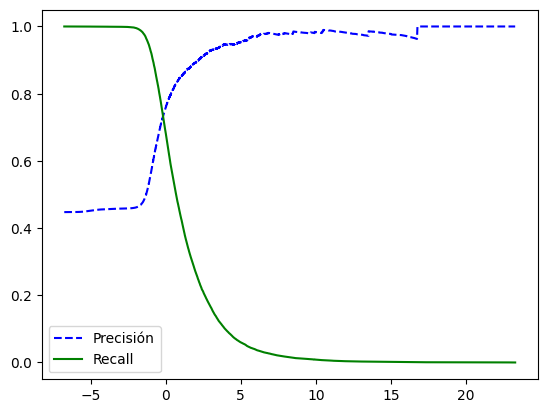

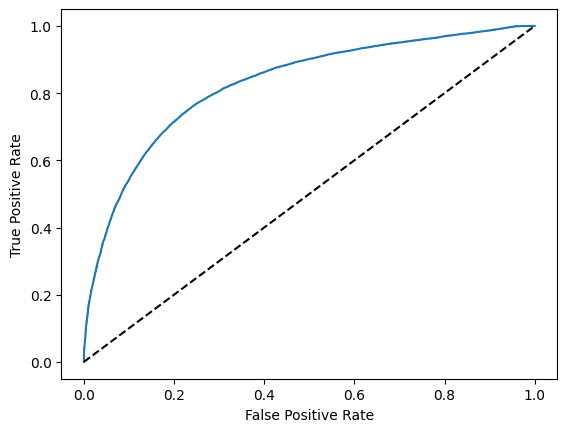

In [98]:
plot_recall_roc(softMax_step_1, X_train, y_train)

### One Tree

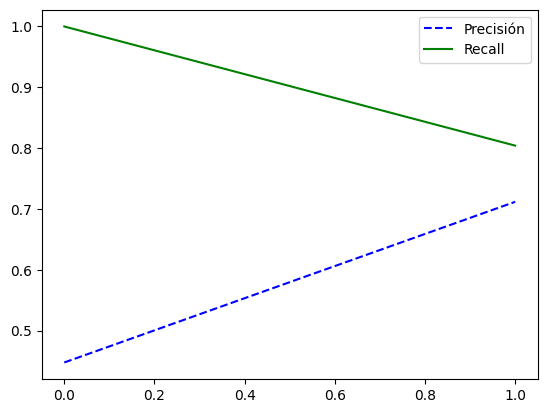

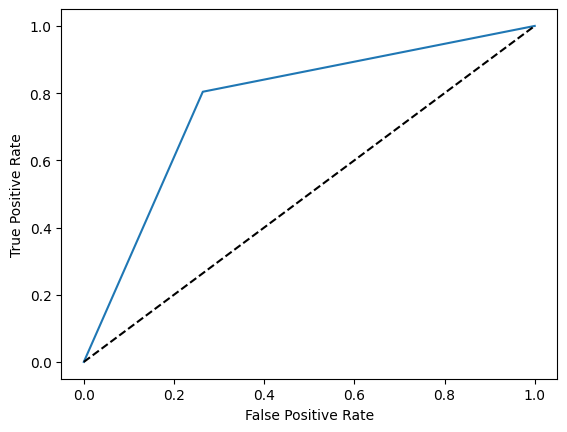

In [99]:
plot_recall_roc(tree_, X_train, y_train, method= 'predict')

### Random Forest

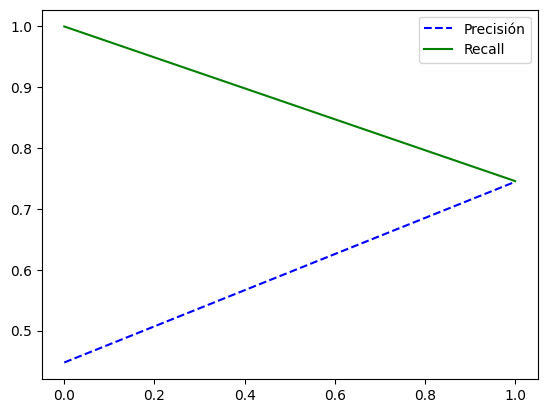

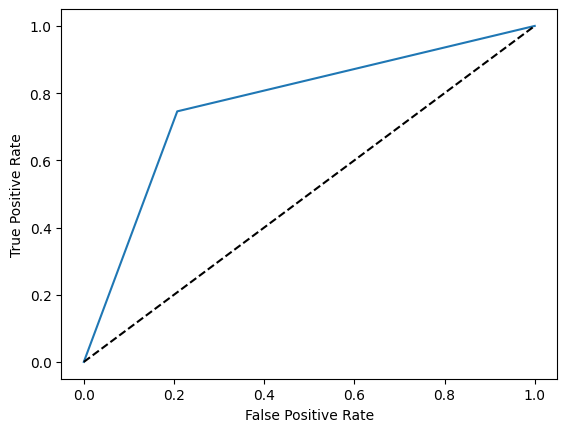

In [143]:
plot_recall_roc(rf, X_train, y_train, method= 'predict')

## Análsis para XGBoost

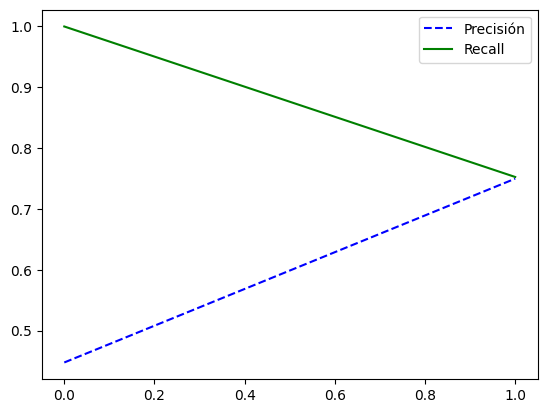

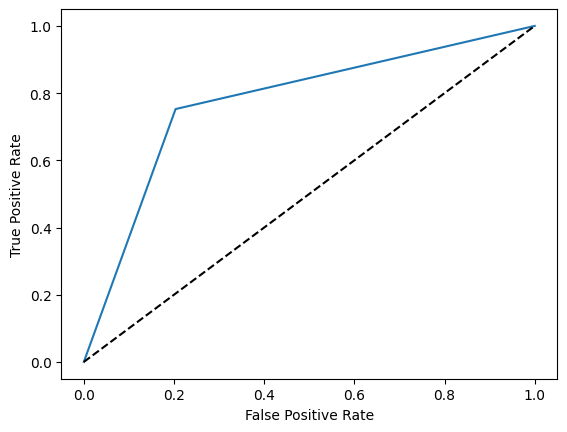

In [144]:
plot_recall_roc(XGB, X_train, y_train, method= 'predict')

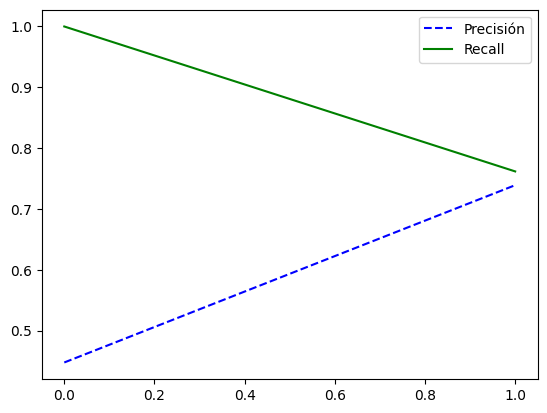

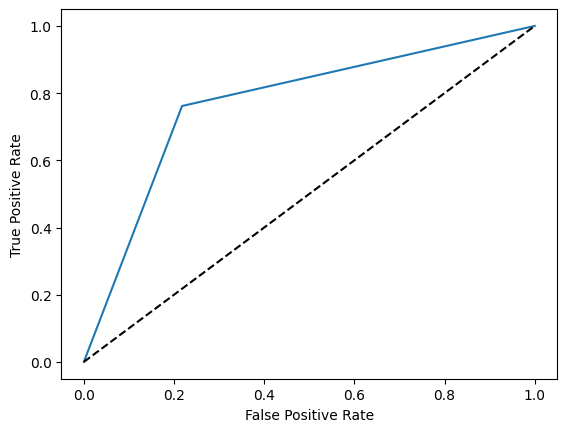

In [145]:
plot_recall_roc(stacking, X_train, y_train, method= 'predict')

## Tomando el primer modelo con mejor rendimiento

In [ ]:
modelos = {
    "SoftMax" : pred_softMax_eta1,
    'Arbol de decisión' : pred_tree_eta1,
    'Random Forest' : pred_rf_eta1,
    'XGBClassifier' : pred_XGB_eta1
}

for nombre, pred_mod in modelos.items():
    scores = f1_score(y_test, pred_mod)
    accu = accuracy_score(y_test, pred_mod)
    prec = precision_score(y_test, pred_mod)
    print(f"{nombre}: F1 CV score = {scores:.4f} | accuracy : {accu:.4f} | precision : {prec:.4f}" )

***

***

## Análsis centrado en la segunda etapa del modelo

En esta etapa se tiene el postulamiento que si el modelo predice  '>30 o <30', que el modelo tenga la capacidad de poder analizar cada categoría idependientemente, así poder analizar cómo se comporta en ambos casos, y observar si los modelos tienen un mejor ajuste.

In [9]:
# Reconfiguración de la variable 
new_y_label_step_2 = {
    '>30' : 1,
    '<30' : 0
}
return_y_label_step_2 = {
    1 : '>30',
    0 : '<30'
}

In [10]:
df_step_2 = df.copy()
df_step_2 = df_step_2.loc[df_step_2["readmitted"].isin(['>30', '<30'])]

In [11]:
df_step_2.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,mb_num_lab_procedures_ct,mb_num_procedures_ct,mb_num_medications_ct,mb_number_outpatient_ct,mb_number_emergency_ct,mb_number_inpatient_ct,mb_number_diagnoses_ct,mb A1c gt 7 ct,mb A1c gt 8 ct,mb A1c Norm ct
0,Female,1,3,59,0,18,0,0,0,9,...,59,0,18,0,0,0,9,0,0,0
4,Male,5,3,31,6,16,0,0,0,9,...,31,6,16,0,0,0,9,0,0,0
6,Male,7,5,73,0,12,0,0,0,8,...,73,0,12,0,0,0,8,0,0,0
7,Female,4,9,47,2,17,0,0,0,9,...,47,2,17,0,0,0,9,0,0,0
8,Male,6,7,62,0,11,0,0,0,7,...,62,0,11,0,0,0,7,0,0,0


In [127]:
df_step_2.shape

(35440, 154)

Observando si por cada categoría el desbalance se mantiene muy grande

In [171]:
Counter(df_step_2["readmitted"])

Counter({'>30': 27487, '<30': 8516})

El desbalance se sigue observando muy grande, dado que se observa que las personas que regresan al hospital es 3.23 veces la de los que regresan en menos de 30 días al hospital. En este caso particular, se va a utilizar CatBoost, especificamente CatBoostClasifier, para mejor el rendimiento de selección de cada unidad.

In [12]:
df_step_2["readmitted_1"] = np.where(
    (df_step_2["readmitted"] == "<30"), 0, 1
)

In [13]:
df_step_2.drop("readmitted", axis = 1, inplace= True)

In [14]:
df_step_2.reset_index(inplace= True)

Los datos al estar, en este etapa particular, muy desbalanceados, se va a empezar analizar mediante un sobremuestreo.

In [15]:
df_step_2.drop('index', axis = 1, inplace= True)

In [16]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=262025)

for ent_index, prueba_index in split.split(df_step_2, df_step_2["readmitted_1"]):
    df_train = df_step_2.loc[ent_index]
    df_test = df_step_2.loc[prueba_index]

print("El split en el DF está listo")

El split en el DF está listo


In [186]:
Counter(df_train["readmitted_1"])

Counter({1: 21989, 0: 6813})

## Realizando análisis

In [17]:
numeric_features = df_train.drop("readmitted_1", axis = 1).select_dtypes(include="int64").columns
object_features = df_train.drop(["readmitted_1"], axis=1).select_dtypes(include="object").columns

In [18]:
(X_train, y_train) = df_train.drop("readmitted_1", axis = 1), df_train["readmitted_1"]
(X_test, y_test) = df_test.drop("readmitted_1", axis = 1), df_test["readmitted_1"]

# Estableciendo los parámteros a los modelos de prepocesamiento

In [189]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ],
    remainder='passthrough'  # Deja pasar las columnas numéricas tal cual
)

In [181]:
softMax_step_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight = 'balanced',
                                  max_iter= 1000,
                                  solver= 'lbfgs',
                                  random_state= 362025
                                  ))
    ])

In [182]:
%%time
grid_softMax = [{
    "model__C": [0.01, 0.1, 1, 5, 10] # Los parámetros que se pueden aplicar para el ajuste de este posible modelo
    }]

grid_search_softMax = GridSearchCV(softMax_step_2, grid_softMax, cv = 5, scoring= 'f1')

grid_search_softMax.fit(X_train, y_train)

CPU times: total: 2min 22s
Wall time: 2min 31s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_procedures_ct', 'mb...
                                                                         Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=362025))]),
             param_grid=[{'model__C': [0.01, 0.1, 1, 5, 10]}], scoring='f1')

In [183]:
grid_search_softMax.best_params_

{'model__C': 10}

### El mejor modelo obtenido con SoftMax

In [184]:
softMax_step_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight = 'balanced',
                                  max_iter= 1000,
                                  C = 10,
                                  solver= 'lbfgs',
                                  random_state= 362025
                                  ))
    ])

In [185]:
%%time
softMax_step_2.fit(X_train, y_train)

CPU times: total: 13.5 s
Wall time: 14.9 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_procedures_ct', 'mb_num_procedures_ct',
       'mb_num_...
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, random_state=362025))])

In [186]:
pred_softMax = softMax_step_2.predict(X_test)

In [187]:
f1_score(y_test, pred_softMax)

0.7893541647742756

In [188]:
confusion_matrix(y_test, pred_softMax)

array([[ 537, 1166],
       [1153, 4345]])

In [189]:
accuracy_score(y_test, pred_softMax)

0.6779613942507985

In [190]:
precision_score(y_test, pred_softMax)

0.7884231536926147

In [191]:
joblib.dump(softMax_step_2, gen_path / 'models' / 'softMax_step_2_eta2_T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\softMax_step_2_eta2_T002.pkl']

In [72]:
softMax_load = joblib.load(gen_path / 'models' / 'softMax_step_2_eta2_T002.pkl')

In [53]:
pred_softMax_eta2 = softMax_load.predict(X_test)

### Decision Tree Classifier

In [194]:
# Este no requiere preprocesador con estandirzación
tree_step_2 = Pipeline(steps=[('preprocessor', preprocessor2),
                           ('model', DecisionTreeClassifier(random_state= 362025, 
                                                            class_weight= 'balanced'))])

grid_tree = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
}

In [195]:
%%time
grid_search_tree = GridSearchCV(tree_step_2, grid_tree, cv = 5, scoring= 'f1')
grid_search_tree.fit(X_train, y_train)

CPU times: total: 5min 1s
Wall time: 5min 4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                                       ('model',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=362025))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 5, 10, 20],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='f1')

In [196]:
grid_search_tree.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': None,
 'model__min_samples_split': 2}

### Modelo Tree con mejor ajuste

In [197]:
tree_step_2 = Pipeline(steps=[('preprocessor', preprocessor2),
                           ('model', DecisionTreeClassifier(random_state= 362025, 
                                                            criterion = 'entropy',
                                                            min_samples_split = 2,
                                                            class_weight= 'balanced'))])

In [199]:
%%time
tree_step_2.fit(X_train, y_train)

CPU times: total: 6.11 s
Wall time: 6.2 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        random_state=362025))])

In [200]:
pred_tree = tree_step_2.predict(X_test)

In [201]:
confusion_matrix(y_test, pred_tree)

array([[ 556, 1147],
       [1214, 4284]])

In [202]:
joblib.dump(tree_step_2, gen_path / 'models' / 'tree_step_2_eta2_T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\tree_step_2_eta2_T002.pkl']

In [31]:
tree_load_eta2 = joblib.load(gen_path / 'models' / 'tree_step_2_eta2_T002.pkl')

In [32]:
pred_tree_eta2 = tree_load_eta2.predict(X_test)

### Realización de entrenamiento con Random Forest

In [206]:
rf_step_2 = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model', RandomForestClassifier(
    random_state=362025,
    class_weight= 'balanced',
    n_jobs= -1
    ))
])

grid_rf = {
    'model__n_estimators': [55, 100, 195, 200],
    'model__max_depth': [6, 15, 20],
    'model__max_features': ['sqrt', 'log2']
}

In [207]:
grid_search_rf = GridSearchCV(rf_step_2, grid_rf, cv = 5, scoring= 'f1')

In [208]:
%%time
grid_search_rf.fit(X_train, y_train)

CPU times: total: 6min 27s
Wall time: 1min 58s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=362025))]),
             param_grid={'model__max_depth': [6, 15, 20],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__n_estimators': [55, 100, 195, 200]},
             scoring='f1')

In [209]:
grid_search_rf.best_params_

{'model__max_depth': 20,
 'model__max_features': 'sqrt',
 'model__n_estimators': 200}

### El mejor modelo de desempeño

In [210]:
rf_step_2 = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model', RandomForestClassifier(
    random_state= 362025,
    class_weight= 'balanced',
    max_depth= 20,
    max_features= 'sqrt',
    n_estimators= 200,
    n_jobs= -1
    ))
])

In [211]:
%%time
rf_step_2.fit(X_train, y_train)

CPU times: total: 13.5 s
Wall time: 2.46 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=362025))])

In [212]:
pred_rf = rf_step_2.predict(X_test)

confusion_matrix(y_test, pred_rf)

array([[ 916,  787],
       [1888, 3610]])

In [213]:
joblib.dump(rf_step_2, gen_path / 'models' / 'rf_step_2_eta2_T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\rf_step_2_eta2_T002.pkl']

In [33]:
rf_step_2_load = joblib.load(gen_path / 'models' / 'rf_step_2_eta2_T002.pkl')

In [34]:
pred_rf2_eta2 = rf_step_2_load.predict(X_test)

## Modelo realizado con CatBoostClassifier

In [219]:
param_CatB = {
    'model__iterations': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 8]
}

In [74]:
np.unique(y_train)

array([0, 1])

In [75]:
Counter(y_train)

Counter({1: 21643, 0: 6709})

In [216]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y= y_train)

In [217]:
CatBoost = Pipeline(
    steps= [
        ('preprocessor', preprocessor2),
        (
        ("model", CatBoostClassifier(silent=True,
                                    class_weights = weights,
                                    random_state=362025))
        )
    ]
)

In [ ]:
%%time
grid_search_CatBoost = GridSearchCV(CatBoost, param_CatB, cv = 5, scoring= 'f1', verbose= 0)

grid_search_CatBoost.fit(X_train, y_train)

In [78]:
grid_search_CatBoost.best_params_

{'model__depth': 8, 'model__iterations': 500, 'model__learning_rate': 0.1}

In [221]:
CatBoost = Pipeline(
    steps= [
        ('preprocessor', preprocessor2),
        (
        ("model", CatBoostClassifier(silent=True,
                                    depth = 8,
                                    class_weights = weights,
                                    iterations = 500,
                                    learning_rate = 0.1,
                                    random_state=362025))
        )
    ]
)

In [222]:
CatBoost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001F86AF242B0>)])

In [223]:
pred_CatB = CatBoost.predict(X_test)

In [224]:
f1_score(y_test, pred_CatB)

0.7599114509961763

In [225]:
confusion_matrix(y_test, pred_CatB)

array([[1039,  664],
       [1722, 3776]])

In [226]:
accuracy_score(y_test, pred_CatB)

0.6686571309540341

In [227]:
precision_score(y_test, pred_CatB)

0.8504504504504504

In [228]:
joblib.dump(CatBoost, gen_path / 'models' / 'CatBoost_step_2_eta2_T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\CatBoost_step_2_eta2_T002.pkl']

In [41]:
catBoost2_load = joblib.load(gen_path / 'models' / 'CatBoost_step_2_eta2_T002.pkl')

In [42]:
pred_CatB2_eta2 = catBoost2_load.predict(X_test)

## Analizando con overfiting

In [233]:
CatBoost0 = Pipeline(
    steps= [
        ('preprocessor', preprocessor2),
        (
        ("model", CatBoostClassifier(silent=True,
                                    depth = 8,
                                    class_weights = [4, 1],
                                    iterations = 500,
                                    learning_rate = 0.1,
                                    random_state=362025))
        )
    ]
)

In [235]:
%%time
CatBoost0.fit(X_train, y_train)

CPU times: total: 3min 37s
Wall time: 45.7 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001F81B337490>)])

In [236]:
pred_catB0 = CatBoost0.predict(X_test)

confusion_matrix(y_test, pred_catB0)

array([[1192,  511],
       [2154, 3344]])

In [237]:
CatBoost1 = Pipeline(
    steps= [
        ('preprocessor', preprocessor2),
        (
        ("model", CatBoostClassifier(silent=True,
                                    depth = 8,
                                    class_weights = [1, 3],
                                    iterations = 500,
                                    learning_rate = 0.1,
                                    random_state=362025))
        )
    ]
)

In [239]:
%%time
CatBoost1.fit(X_train, y_train)

CPU times: total: 3min 22s
Wall time: 41.6 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001F81B3369B0>)])

In [240]:
pred_catB1 = CatBoost1.predict(X_test)

confusion_matrix(y_test, pred_catB1)

array([[  36, 1667],
       [   5, 5493]])

## Modelo desarrollado con descenso del gradiente

In [241]:
from sklearn.linear_model import SGDClassifier

In [242]:
SGD = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SGDClassifier(n_jobs=-1,
                            tol = 0.001,
                            penalty = 'l1',
                            class_weight = 'balanced',
                            max_iter = 5000,
                            loss = 'modified_huber',
                            alpha = 0.001
                            ))
])

In [243]:
%%time
SGD.fit(X_train, y_train)

CPU times: total: 7.91 s
Wall time: 8.06 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_procedures_ct', 'mb_num_procedures_ct',
       'mb_num_...
                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'discharge_disposition',
       'admission_source', 'diagnosis_tuple'],
      dtype='object'))])),
                ('model',
                 SGDClassifier(alpha=0.001, class_weight='balanced',
                               loss='modified_huber', max_iter=5000, n_jobs=-1,
                               penalty='l1'))])

In [244]:
pred_test3 = SGD.predict(X_test)

confusion_matrix(y_test, pred_test3)

array([[ 779,  924],
       [1462, 4036]])

In [245]:
f1_score(y_test, pred_test3)

0.7718493019697839

In [246]:
accuracy_score(y_test, pred_test3)

0.6686571309540341

In [247]:
precision_score(y_test, pred_test3)

0.8137096774193548

In [248]:
pred_test4 = SGD.predict(X_train)

accuracy_score(y_train, pred_test4)

0.6746753697659885

In [249]:
f1_score(y_train, pred_test4)

0.7752674245694824

In [250]:
precision_score(y_train, pred_test4)

0.8201979193098199

In [251]:
joblib.dump(SGD, gen_path / 'models' / 'SGD_step_2_eta2_T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\SGD_step_2_eta2_T002.pkl']

In [35]:
SDG2_load = joblib.load(gen_path / 'models' / 'SGD_step_2_eta2_T002.pkl')

In [36]:
pred_SGD2_eta2 = SDG2_load.predict(X_test)


# Último intento de XGBoost

In [254]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1],
    'model__n_estimators': [300, 500],
    'model__subsample': [0.7, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
}

random_search1 =  Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=362025,
    verbose = 0
)

     )
])

random_search = RandomizedSearchCV(
    estimator=random_search1,
    param_distributions= param_grid,
    scoring='average_precision',  ## Enfocado a 'AP'
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=362025,
    n_jobs=-1
)

random_search.fit(
    X_train, y_train
)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['time_in_hospital', 'MP_DM_payer_ind', 'expiration_ind',
       'mb_admission_grp_1_ct', 'mb_admission_grp_2_ct',
       'mb_discharge_grp_1_ct', 'mb_discharge_grp_2_ct',
       'mb_admission_type_ct', 'distinct_diag_count', 'diag_1_428_ind',
       ...
       'mh_hi...
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.8, 1.0],
                                        'model__learning_rate': [0.05, 0.1],
                                        'model__max_depth': [3, 5, 7],
                                        'model__n_estimators': [300, 500],
                                        'model__subsample': [0.7, 1.0]},
                   random_state=362025, scoring='average_precision', verbose=2)

In [26]:
random_search.best_params_

{'model__subsample': 1.0,
 'model__n_estimators': 300,
 'model__max_depth': 3,
 'model__learning_rate': 0.05,
 'model__colsample_bytree': 0.8}

In [255]:
XGB =  Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=362025,
    subsample = 1,
    n_estimators = 300,
    max_depth = 3,
    learning_rate = 0.05,
    colsample_bytree = 0.8,
    verbose = 0
)

     )
])

In [256]:
%%time
XGB.fit(X_train, y_train)

CPU times: total: 11.5 s
Wall time: 2.22 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_procedures_ct', 'mb_num_procedures_ct',
       'mb_num_...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [257]:
pred_test6 = XGB.predict(X_test)

confusion_matrix(y_test, pred_test6)

array([[1194,  509],
       [2128, 3370]])

In [258]:
precision_score(y_test, pred_test6)

0.868780613560196

In [259]:
accuracy_score(y_test, pred_test6)

0.633800860991529

In [260]:
f1_score(y_test, pred_test6)

0.718779993601365

In [30]:
Counter(y_test)

Counter({1: 5411, 0: 1677})

In [261]:
joblib.dump(XGB, gen_path / 'models' / 'XGB_step_2_eta2_T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\XGB_step_2_eta2_T002.pkl']

In [50]:
XGB2_load = joblib.load(gen_path / 'models' / 'XGB_step_2_eta2_T002.pkl')

In [ ]:
pred_XGB2_eta2 = XGB2_load.predict(X_test)

## Útimo modelo desarrollado con Stacking

In [266]:
stacking = StackingClassifier(
    estimators=[
        ("Cat1", CatBoost1),
        ("Cat0", CatBoost0),
        ('SoftMax', softMax_step_2),
        ('Descenso del gradiente', SGD),
        ('XGBoost', XGB)
        
    ],
        final_estimator= XGBClassifier(
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=362025,
    subsample = 1,
    n_estimators = 300,
    max_depth = 3,
    learning_rate = 0.05,
    colsample_bytree = 0.8,
    verbose = 0
),
    n_jobs= -1
)

In [267]:
%%time
stacking.fit(X_train, y_train)

CPU times: total: 2.52 s
Wall time: 6min 2s


StackingClassifier(estimators=[('Cat1',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('cat',
                                                                                  OneHotEncoder(drop='first',
                                                                                                handle_unknown='ignore'),
                                                                                  Index(['gender', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'admission_type', 'disc...
                                                 gamma=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.05,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=3, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=300, n_jobs=None,
                                                 num_parallel_tree=None, ...),
                   n_jobs=-1)

In [268]:
joblib.dump(stacking, gen_path / 'models' / 'stacking_step_2_eta2_T002.pkl')

['c:\\Users\\Steve\\University\\UCR 2025\\Semester I\\Data Mining\\Investigaciones\\Inv-3\\models\\stacking_step_2_eta2_T002.pkl']

In [269]:
pred_last = stacking.predict(X_test)

confusion_matrix(y_test, pred_last)

array([[1218,  485],
       [2198, 3300]])

In [195]:
f1_score(y_test, pred_last)

0.6890478811227297

In [196]:
accuracy_score(y_test, pred_last)

0.6014390519187359

In [294]:
stacking_2_load = joblib.load(gen_path / 'models' / 'stacking_step_2_eta2_T002.pkl')

In [295]:
stacking_2_pred = stacking_2_load.predict(X_test)

In [197]:
precision_score(y_test, pred_last)

0.8519324986390855

## Evaluación sin usar los sobre ajustes

In [271]:
stacking2 = StackingClassifier(
    estimators=[
        ('SoftMax', softMax_step_2),
        ('Descenso del gradiente', SGD),
        ('XGBoost', XGB)
        
    ],
        final_estimator= XGBClassifier(
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=362025,
    subsample = 1,
    n_estimators = 300,
    max_depth = 3,
    learning_rate = 0.05,
    colsample_bytree = 0.8,
    verbose = 0
),
    n_jobs= -1
)

In [272]:
%%time
stacking2.fit(X_train, y_train)

CPU times: total: 2.17 s
Wall time: 2min 24s


StackingClassifier(estimators=[('SoftMax',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  StandardScaler(),
                                                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'MP_DM_payer_ind',
       'mb_admission_grp_1_ct',
       ...
       'mb_num_lab_proc...
                                                 gamma=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.05,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=3, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=300, n_jobs=None,
                                                 num_parallel_tree=None, ...),
                   n_jobs=-1)

In [293]:
pred_stacking2_eta2 = stacking2.predict(X_test)

## Análsisi de performance

In [55]:
modelos = {
    "SoftMax" : pred_softMax_eta2,
    'Arbol de decisión' : pred_tree_eta2,
    'Random Forest' : pred_rf2_eta2,
    'XGBClassifier' : pred_XGB2_eta2,
    'CatBoost2' : pred_XGB2_eta2,
    'Descenso' : pred_SGD2_eta2,
    'stacking 2' : stacking_2_pred
}
for nombre, pred_mod in modelos.items():
    scores = f1_score(y_test, pred_mod)
    accu = accuracy_score(y_test, pred_mod)
    prec = precision_score(y_test, pred_mod)
    print(f"{nombre}: F1 CV score = {scores:.4f} | accuracy : {accu:.4f} | precision : {prec:.4f}" )

SoftMax: F1 CV score = 0.7894 | accuracy : 0.6780 | precision : 0.7884
Arbol de decisión: F1 CV score = 0.7840 | accuracy : 0.6721 | precision : 0.7888
Random Forest: F1 CV score = 0.7297 | accuracy : 0.6285 | precision : 0.8210
XGBClassifier: F1 CV score = 0.7188 | accuracy : 0.6338 | precision : 0.8688
CatBoost2: F1 CV score = 0.7188 | accuracy : 0.6338 | precision : 0.8688
Descenso: F1 CV score = 0.7718 | accuracy : 0.6687 | precision : 0.8137
stacking 2: F1 CV score = 0.7110 | accuracy : 0.6274 | precision : 0.8719


En este caso particular ha ganado SoftMax

In [56]:
import numpy as np
from sklearn.metrics import roc_curve, balanced_accuracy_score, confusion_matrix

# 1) Probabilidades de validación
probas = softMax_load.predict_proba(X_test)[:,1]
# 2) Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, probas)
# 3) Balanced Accuracy para cada umbral
bacc = (tpr + (1 - fpr)) / 2
# 4) Selecciono el mejor umbral
best_idx = np.argmax(bacc)
best_thresh = thresholds[best_idx]
print("Mejor umbral (max Balanced Acc):", best_thresh)

# 5) Aplico al test
y_pred = (softMax_load.predict_proba(X_test)[:,1] >= best_thresh).astype(int)

# 6) Reviso la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz ajustada:\n", cm)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))


Mejor umbral (max Balanced Acc): 0.7301696323931242
Matriz ajustada:
 [[1108  595]
 [2922 2576]]
Balanced Accuracy: 0.5595752856908197


In [57]:
confusion_matrix(y_test, pred_softMax_eta2)

array([[ 537, 1166],
       [1153, 4345]])

## Combinación de modelos

In [58]:
class HierarchicalReadmissionModel:
    def __init__(self, model_stage1, model_stage2,
                 thresh_stage1=0.5,  # umbral para decidir regresa vs no
                 thresh_stage2=0.5   # umbral para decidir >30 vs <30
                ):
        self.model_stage1 = model_stage1
        self.model_stage2 = model_stage2
        self.th1 = thresh_stage1
        self.th2 = thresh_stage2

    def predict(self, X):
        # 1) ETAPA 1: probabilidades de "regresa" (clase 1)
        proba1 = self.model_stage1.predict_proba(X)[:,1]
        y1 = (proba1 >= self.th1).astype(int)

        # Inicializo todos como NO (0)
        final_pred = np.zeros_like(y1, dtype=int)

        # 2) Sólo quienes superan el umbral pasan a etapa 2
        idx = np.where(y1 == 1)[0]
        if idx.size > 0:
            X2 = X.iloc[idx]
            # Probabilidades de ">30" (clase 1) en etapa 2
            proba2 = self.model_stage2.predict_proba(X2)[:,1]
            y2 = (proba2 >= self.th2).astype(int)

            # 0 => <30  → asigno etiqueta 1
            # 1 => >30  → asigno etiqueta 2
            for i, p in zip(idx, y2):
                final_pred[i] = 1 if p == 0 else 2

        return final_pred

In [ ]:
XGB_load_eta1 = joblib.load(gen_path / 'models' / 'XGB_eta1_T002.pkl')
stacking_2_load = joblib.load(gen_path / 'models' / 'stacking_step_2_eta2_T002.pkl')

hierarchical_model = HierarchicalReadmissionModel(XGB_load_eta1, stacking_2_load)

In [62]:
pred_test_last = hierarchical_model.predict(df.drop(["readmitted"], axis = 1))

In [64]:
y_grand = df["readmitted"].map(
    {
        ">30" : 2,
        "<30" : 1,
        "NO"  : 0
    }
)

In [65]:
confusion_matrix(y_grand, pred_test_last)

array([[39156,   904,  2680],
       [ 1440,  6014,  1062],
       [ 8233,  9479,  9775]])

In [66]:
accuracy_score(y_grand, pred_test_last)

0.697776310275199

In [67]:
precision_score(y_grand, pred_test_last, average= None)

array([0.80190051, 0.36677441, 0.72316342])

In [68]:
f1_score(y_grand, pred_test_last, average= None)

array([0.85522393, 0.48280014, 0.47678275])

## Analizando todo con el modelo final

In [19]:
SDG2_load = joblib.load(gen_path / 'models' / 'SGD_step_2_eta2_T002.pkl')
pred_SGD2_eta2 = SDG2_load.predict(X_test)

c:\Users\Steve\University\UCR 2025\Semester I\Data Mining\Investigaciones\Inv-3\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [21]:
confusion_matrix(y_test, pred_SGD2_eta2)

array([[ 779,  924],
       [1462, 4036]])

In [22]:
XGB2_load = joblib.load(gen_path / 'models' / 'XGB_step_2_eta2_T002.pkl')
pred_XGB2_eta2 = XGB2_load.predict(X_test)

c:\Users\Steve\University\UCR 2025\Semester I\Data Mining\Investigaciones\Inv-3\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [23]:
confusion_matrix(y_test, pred_XGB2_eta2)

array([[1194,  509],
       [2128, 3370]])

In [26]:
stacking_2_load = joblib.load(gen_path / 'models' / 'stacking_step_2_eta2_T002.pkl')
stacking_2_pred = stacking_2_load.predict(X_test)

In [27]:
confusion_matrix(y_test, stacking_2_pred)

array([[1218,  485],
       [2198, 3300]])

## Selección del mejor modelo para realizar las predicciones

In [29]:
## Mejores modelos
SDG2_load = joblib.load(gen_path / 'models' / 'SGD_step_2_eta2_T002.pkl')
XGB2_load = joblib.load(gen_path / 'models' / 'XGB_step_2_eta2_T002.pkl')
stacking_2_load = joblib.load(gen_path / 'models' / 'stacking_step_2_eta2_T002.pkl')


In [43]:
models_final = {
    "SoftMax" : softMax_load,
    "Arbol de decisión" : tree_load_eta2,
    "Random Forest" : rf_step_2_load,
    "Descenso del Gradiente" : SDG2_load,
    "XGBoost" : XGB2_load,
    "Staking" : stacking_2_load,
    "CatBoost" : catBoost2_load
}

In [44]:
from tabulate import tabulate

In [49]:
rows = []
for name, model_load in models_final.items():
    hm = HierarchicalReadmissionModel(XGB_load_eta1, model_load)
    preds = hm.predict(X_test)
    
    f1 = f1_score(y_test, preds, average=None)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average=None)
    
    rows.append([
        name,
        acc,
        f1[0], f1[1], f1[2],
        prec[0], prec[1], prec[2]
    ])

headers = ["Model", "Acc", "F1NO", "F1<30d", "F1>30", "PrecNO", "Prec<30d", "Prec>30"]
print(tabulate(rows, headers=headers, floatfmt=".4f", tablefmt="github"))


| Model                  |    Acc |   F1<30d |   F1>30 |   Prec<30d |   Prec>30 |
|------------------------|--------|----------|---------|------------|-----------|
| SoftMax                | 0.1590 |   0.1540 |  0.2531 |     0.1444 |    0.6496 |
| Arbol de decisión      | 0.1725 |   0.1540 |  0.2766 |     0.1444 |    0.6623 |
| Random Forest          | 0.2795 |   0.1540 |  0.4271 |     0.1444 |    0.6628 |
| Descenso del Gradiente | 0.2061 |   0.1540 |  0.3257 |     0.1444 |    0.6368 |
| XGBoost                | 0.3070 |   0.1540 |  0.4523 |     0.1444 |    0.6357 |
| Staking                | 0.3161 |   0.1540 |  0.4630 |     0.1444 |    0.6394 |
| CatBoost               | 0.2576 |   0.1540 |  0.3919 |     0.1444 |    0.6212 |


# Comparando con el modelo más grande

In [190]:
catBoost2_load = joblib.load(gen_path / 'models' / 'CatBoost_step_2_eta2_T002.pkl')

In [191]:
pred_CatB_eta2 = catBoost2_load.predict(X_test)

In [204]:
probas = catBoost2_load.predict_proba(X_test)[:, 1]  

threshold = 0.48

y_pred_custom = (probas >= threshold).astype(int)
confusion_matrix(y_test, y_pred_custom)

array([[ 966,  737],
       [1529, 3969]])

In [115]:
modelos = {
    "SoftMax"           : pred_softMax_eta1,
    "Árbol de decisión" : tree_pred_eta1,
    "Random Forest"     : pred_rf_eta1,
    "AdaBoost"          : pred_adaB_eta1,
    "Stacking"          : pred_stacking_eta1,
    "Catboost"          : pred_CatB_eta2
}

rows = []
for name, preds in modelos.items():
    f1_vals   = f1_score(y_test, preds, average=None)
    prec_vals = precision_score(y_test, preds, average=None)
    acc       = accuracy_score(y_test, preds)
    rows.append([
        name,
        acc,
        f1_vals[0], f1_vals[1], f1_vals[2],
        prec_vals[0], prec_vals[1], prec_vals[2]
    ])


headers = ["Model", "Acc", "F1NO", "F1<30d", "F1>30", "PrecNO", "Prec<30d", "Prec>30"]
print(tabulate(rows, headers=headers, floatfmt=".4f", tablefmt="github"))

| Model             |    Acc |   F1NO |   F1<30d |   F1>30 |   PrecNO |   Prec<30d |   Prec>30 |
|-------------------|--------|--------|----------|---------|----------|------------|-----------|
| SoftMax           | 0.6487 | 0.7951 |   0.3236 |  0.5117 |   0.7611 |     0.2802 |    0.6011 |
| Árbol de decisión | 0.6510 | 0.8267 |   0.4163 |  0.4345 |   0.8021 |     0.3083 |    0.5997 |
| Random Forest     | 0.5860 | 0.7889 |   0.3406 |  0.3233 |   0.7694 |     0.2333 |    0.5740 |
| AdaBoost          | 0.6766 | 0.8362 |   0.4398 |  0.4807 |   0.8004 |     0.3453 |    0.6274 |
| Stacking          | 0.6683 | 0.8328 |   0.4084 |  0.4736 |   0.7965 |     0.3233 |    0.6126 |


# Unión de los modelos

In [ ]:
class HierarchicalReadmissionModel:
    def __init__(self, model_stage1, model_stage2,
                 thresh_stage1=0.5,  # umbral para decidir regresa vs no
                 thresh_stage2=0.5   # umbral para decidir >30 vs <30
                ):
        self.model_stage1 = model_stage1
        self.model_stage2 = model_stage2
        self.th1 = thresh_stage1
        self.th2 = thresh_stage2

    def predict(self, X):
        # 1) ETAPA 1: probabilidades de "regresa" (clase 1)
        proba1 = self.model_stage1.predict_proba(X)[:,1]
        y1 = (proba1 >= self.th1).astype(int)

        # Inicializo todos como NO (0)
        final_pred = np.zeros_like(y1, dtype=int)

        # 2) Sólo quienes superan el umbral pasan a etapa 2
        idx = np.where(y1 == 1)[0]
        if idx.size > 0:
            X2 = X.iloc[idx]
            # Probabilidades de ">30" (clase 1) en etapa 2
            proba2 = self.model_stage2.predict_proba(X2)[:,1]
            y2 = (proba2 >= self.th2).astype(int)

            # 0 => <30  → asigno etiqueta 1
            # 1 => >30  → asigno etiqueta 2
            for i, p in zip(idx, y2):
                final_pred[i] = 1 if p == 0 else 2

        return final_pred

In [83]:
modelo = HierarchicalReadmissionModel(
    model_stage1=XGB_load_eta1,
    model_stage2=softMax_load,
    thresh_stage1=0.5,
    thresh_stage2=0.7301696323931242
)


## Análisis con todos los datos completos

In [131]:
modelo = HierarchicalReadmissionModel(
    model_stage1=XGB_load_eta1,
    model_stage2=softMax_load,
    thresh_stage1=0.53,
    thresh_stage2=0.4
)

In [141]:
pred_test_last = modelo.predict(df_test.drop(["readmitted"], axis = 1))

## Encontrando los mejores umbrales

In [88]:
X = df.drop("readmitted", axis=1)
y_true = df["readmitted"].map({">30": 2, "<30": 1, "NO": 0}).values

# Grid de umbrales: de 0.1 a 0.9 en saltos de 0.01
th1_range = np.arange(0.4, 0.53, 0.01)
th2_range = np.arange(0.4, 0.81, 0.01)

best_acc = 0.0
best_th1, best_th2 = None, None

for th1 in th1_range:
    for th2 in th2_range:
        modelo = HierarchicalReadmissionModel(
            model_stage1=XGB_load_eta1,
            model_stage2=softMax_load,
            thresh_stage1=th1,
            thresh_stage2=th2
        )
        y_pred = modelo.predict(X)
        acc = accuracy_score(y_true, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_th1, best_th2 = th1, th2

print(f"Mejor umbral encontrado: "
      f"Stage1 = {best_th1:.4f}, Stage2 = {best_th2:.4f} "
      f"→ Accuracy = {best_acc:.4f}")

Mejor umbral encontrado: Stage1 = 0.5300, Stage2 = 0.4000 → Accuracy = 0.7734


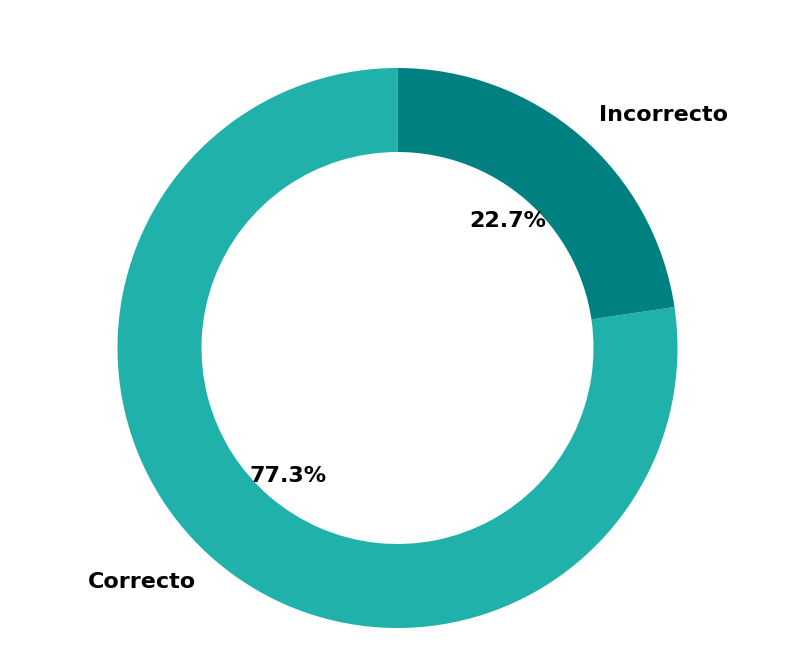

In [92]:
aciertos = y_df == pred_test_last

n_aciertos = np.sum(aciertos)
n_errores = len(aciertos) - n_aciertos

sizes = [n_aciertos, n_errores]
labels = ['Correcto', 'Incorrecto']
colors = ['#20B2AA', '#008080']

fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90,
    colors=colors,
    wedgeprops={'width':0.3}
)

for text in texts:
    text.set_fontsize(16)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(16)
    autotext.set_fontweight('bold')

ax.axis('equal')
plt.title(' ', fontsize=20, fontweight='bold')
plt.show()
